
Лабораторная работа 4
Убедиться в нестабильности одиночного дерева на своих данных
Отобрать самые важные признаки случайным лесом, сравнить с отбором признаков линейным методом c L1-регуляризацией
Сравнить качество работы случайного леса без кросс-валидации с кросс-валидации
Сравнить качество работы и время обучения леса с градиентным бустингом над решающими деревьями, подобрав для каждого оптимальные параметры. Градиентный бустинг обучать на видеокарте.

In [1]:
# загрузим данные

#импорт необходимых модулей
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pylab import rcParams

data = pd.read_csv('C:\\heart.csv', sep=',')
data = data.drop(['Unnamed: 0'], axis='columns')
data = data.drop(['oldpeak'], axis='columns')

def gender_oppression(gender):
    if gender == 'male':
        return 1
    return 0

data['sex'] = data['sex'].apply(gender_oppression)

def chest(pain):
    if pain == 'light':
        return 0
    if pain == 'medium':
        return 1
    if pain == 'hard':
        return 2
    if pain == 'very hard':
        return 3
    return 4

data['cp'] = data['cp'].apply(chest)

X = data[data.columns[:-1]]
y = data['target']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 227 entries, 54 to 145
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   age       227 non-null    int64
 1   sex       227 non-null    int64
 2   cp        227 non-null    int64
 3   trestbps  227 non-null    int64
 4   chol      227 non-null    int64
 5   fbs       227 non-null    int64
 6   restecg   227 non-null    int64
 7   thalach   227 non-null    int64
 8   exang     227 non-null    int64
 9   slope     227 non-null    int64
 10  ca        227 non-null    int64
 11  thal      227 non-null    int64
dtypes: int64(12)
memory usage: 23.1 KB


Нестабильность одиночного дерева

In [2]:
#необходимый импорт

import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import pylab as plt
import seaborn as sns
from matplotlib import pyplot as plt



Оценим счет precision одного дерева:

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score

#max_features=3
clf_tree = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=15)

clf_tree.fit(X_train, y_train)

predicted = clf_tree.predict(X_test)

prec_score = precision_score(y_test, predicted)

print('precision_score:', prec_score)

precision_score: 0.76


Нарисуем дерево для понимания работы. Покажем дерево заказчику.

In [4]:
from ipywidgets import Image
from io import StringIO
import pydotplus
from sklearn.tree import export_graphviz

my_feature_names = ['age','sex','cp','trestbps','chol','fbs', 'restecg', 'thalach', 'exang', 'slope', 'ca', 'thal'  ]

dot_data = StringIO()
export_graphviz(clf_tree, feature_names=my_feature_names,
               out_file=dot_data, filled=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(value=graph.create_png())

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x05\x0b\x00\x00\x01\xf1\x08\x06\x00\x00\x00\xca\x85\…


Случайный лес без кросс-валидации и с кросс-валидацией


In [14]:
# без кросс-валидацией (predict по тест данным)

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=10, max_depth=5).fit(X_train, y_train)

predicted_rf = rf.predict(X_test)

prec_score_rand_forest = precision_score(y_test, predicted_rf)

print('prec_score_rand_forest:', prec_score_rand_forest)

prec_score_rand_forest: 0.8611111111111112


In [15]:
# для сравнения с градиентом в конце лабы узнаем лучшие гиперпараметры и значение при этих парамтерах

max_score = 0

for n_trees in range(1, 101, 10): # используем разное кол-во деревьев
    for depth in range(1, 16): # используем разную глубину
        p = RandomForestClassifier(n_estimators=n_trees, max_depth=depth).fit(X_train, y_train).predict(X_test)
        score = precision_score(y_test, p)
        if max_score < score and score != 1:
            max_score = score
            print('max_score:',max_score,'\t n_trees:', n_trees, 'depth:', depth)

print('end RandomForestClassifier!\n')
prec_score_rand_forest = max_score
print('prec_score_rand_forest:', prec_score_rand_forest)

max_score: 0.8095238095238095 	 n_trees: 1 depth: 1
max_score: 0.8181818181818182 	 n_trees: 1 depth: 9
max_score: 0.8536585365853658 	 n_trees: 1 depth: 15
max_score: 0.868421052631579 	 n_trees: 11 depth: 5
max_score: 0.8717948717948718 	 n_trees: 11 depth: 6
max_score: 0.875 	 n_trees: 11 depth: 9
max_score: 0.8823529411764706 	 n_trees: 11 depth: 10
max_score: 0.9024390243902439 	 n_trees: 21 depth: 3
max_score: 0.9210526315789473 	 n_trees: 21 depth: 11
end RandomForestClassifier!

prec_score_rand_forest: 0.9210526315789473


In [16]:
# с кросс-валидацией

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

rf = RandomForestClassifier(n_estimators=10, max_depth=5)

score_cross_val = cross_val_score(rf, X_train, y_train, cv=3, scoring='precision')
print('score_cross_val:',score_cross_val)

score_cross_val: [0.75675676 0.80851064 0.7826087 ]


Сравнение леса и градиентного бустинга

In [24]:

from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from catboost import CatBoostClassifier


scores1 = np.ndarray([10, 10])
for i, n_trees in enumerate(np.linspace(1, 100, 10)): # используем разное кол-во деревьев
    for j, depth in enumerate(np.arange(2, 12)): # используем разную глубину
        p = CatBoostClassifier(n_estimators=n_trees, max_depth=depth, task_type="GPU").fit(X_train, y_train).predict(X_test)
        scores1[i, j] = precision_score(y_test, p) #mean_squared_error(y_test, p)
        print('precision_score:', scores1[i, j])

Learning rate set to 0.5


0:	learn: 0.5879796	total: 4.71ms	remaining: 0us
precision_score: 0.8333333333333334
Learning rate set to 0.5
0:	learn: 0.5741065	total: 4.11ms	remaining: 0us
precision_score: 0.9117647058823529
Learning rate set to 0.5
0:	learn: 0.5617805	total: 5.31ms	remaining: 0us
precision_score: 0.9230769230769231
Learning rate set to 0.5
0:	learn: 0.5711749	total: 7.29ms	remaining: 0us
precision_score: 0.875
Learning rate set to 0.5
0:	learn: 0.5785090	total: 7.53ms	remaining: 0us
precision_score: 0.9
Learning rate set to 0.5
0:	learn: 0.5867025	total: 7.05ms	remaining: 0us
precision_score: 0.9333333333333333
Learning rate set to 0.5
0:	learn: 0.6072151	total: 8.74ms	remaining: 0us
precision_score: 0.9
Learning rate set to 0.5
0:	learn: 0.6197312	total: 19.2ms	remaining: 0us
precision_score: 0.8275862068965517
Learning rate set to 0.5
0:	learn: 0.6260667	total: 11.5ms	remaining: 0us
precision_score: 0.8076923076923077
Learning rate set to 0.5
0:	learn: 0.6385378	total: 14ms	remaining: 0us
precis

0:	learn: 0.5867025	total: 40.5ms	remaining: 446ms
1:	learn: 0.5186996	total: 82.1ms	remaining: 410ms
2:	learn: 0.4703190	total: 123ms	remaining: 370ms
3:	learn: 0.4269828	total: 165ms	remaining: 331ms
4:	learn: 0.3922297	total: 207ms	remaining: 290ms
5:	learn: 0.3620184	total: 247ms	remaining: 247ms
6:	learn: 0.3328560	total: 276ms	remaining: 197ms
7:	learn: 0.3121544	total: 316ms	remaining: 158ms
8:	learn: 0.2954366	total: 357ms	remaining: 119ms
9:	learn: 0.2824591	total: 395ms	remaining: 79ms
10:	learn: 0.2661235	total: 429ms	remaining: 39ms
11:	learn: 0.2539003	total: 469ms	remaining: 0us
precision_score: 0.8717948717948718
Learning rate set to 0.5
0:	learn: 0.6072151	total: 42.2ms	remaining: 465ms


1:	learn: 0.5346375	total: 85.9ms	remaining: 429ms
2:	learn: 0.4815897	total: 137ms	remaining: 412ms
3:	learn: 0.4372456	total: 179ms	remaining: 358ms
4:	learn: 0.4036268	total: 222ms	remaining: 311ms
5:	learn: 0.3746106	total: 276ms	remaining: 276ms
6:	learn: 0.3527169	total: 328ms	remaining: 234ms
7:	learn: 0.3306712	total: 374ms	remaining: 187ms
8:	learn: 0.3122989	total: 427ms	remaining: 142ms
9:	learn: 0.2970257	total: 482ms	remaining: 96.4ms
10:	learn: 0.2801369	total: 537ms	remaining: 48.8ms
11:	learn: 0.2649490	total: 579ms	remaining: 0us
precision_score: 0.9
Learning rate set to 0.5


0:	learn: 0.6197312	total: 64.2ms	remaining: 706ms
1:	learn: 0.5535010	total: 132ms	remaining: 658ms
2:	learn: 0.4935229	total: 187ms	remaining: 562ms
3:	learn: 0.4491855	total: 256ms	remaining: 512ms
4:	learn: 0.4163744	total: 312ms	remaining: 437ms
5:	learn: 0.3856215	total: 374ms	remaining: 374ms
6:	learn: 0.3553465	total: 435ms	remaining: 311ms
7:	learn: 0.3302287	total: 491ms	remaining: 246ms
8:	learn: 0.3139175	total: 547ms	remaining: 182ms
9:	learn: 0.3003661	total: 609ms	remaining: 122ms
10:	learn: 0.2859884	total: 659ms	remaining: 59.9ms
11:	learn: 0.2715735	total: 726ms	remaining: 0us
precision_score: 0.9
Learning rate set to 0.5
0:	learn: 0.6260667	total: 82.5ms	remaining: 907ms


1:	learn: 0.5767285	total: 154ms	remaining: 771ms
2:	learn: 0.5229731	total: 235ms	remaining: 704ms
3:	learn: 0.4742264	total: 314ms	remaining: 628ms
4:	learn: 0.4422290	total: 393ms	remaining: 550ms
5:	learn: 0.4145695	total: 477ms	remaining: 477ms
6:	learn: 0.3882209	total: 554ms	remaining: 395ms
7:	learn: 0.3606715	total: 635ms	remaining: 318ms
8:	learn: 0.3398637	total: 704ms	remaining: 235ms
9:	learn: 0.3213840	total: 771ms	remaining: 154ms
10:	learn: 0.3056948	total: 842ms	remaining: 76.6ms
11:	learn: 0.2914048	total: 911ms	remaining: 0us
precision_score: 0.8780487804878049
Learning rate set to 0.5


0:	learn: 0.6385378	total: 82.7ms	remaining: 910ms
1:	learn: 0.5815150	total: 163ms	remaining: 815ms
2:	learn: 0.5386156	total: 235ms	remaining: 704ms
3:	learn: 0.4983639	total: 315ms	remaining: 631ms
4:	learn: 0.4690209	total: 397ms	remaining: 556ms
5:	learn: 0.4340457	total: 472ms	remaining: 472ms
6:	learn: 0.4055778	total: 554ms	remaining: 395ms
7:	learn: 0.3849261	total: 626ms	remaining: 313ms
8:	learn: 0.3601517	total: 713ms	remaining: 238ms
9:	learn: 0.3395470	total: 788ms	remaining: 158ms
10:	learn: 0.3234021	total: 859ms	remaining: 78.1ms
11:	learn: 0.3056451	total: 939ms	remaining: 0us
precision_score: 0.9210526315789473
Learning rate set to 0.5
0:	learn: 0.5879796	total: 18.8ms	remaining: 414ms
1:	learn: 0.5097141	total: 32.5ms	remaining: 342ms
2:	learn: 0.4685165	total: 46.1ms	remaining: 307ms
3:	learn: 0.4413361	total: 59.6ms	remaining: 283ms
4:	learn: 0.4255928	total: 73.5ms	remaining: 264ms
5:	learn: 0.4030805	total: 87.3ms	remaining: 247ms
6:	learn: 0.3855343	total: 101m

8:	learn: 0.3686404	total: 141ms	remaining: 219ms
9:	learn: 0.3610537	total: 154ms	remaining: 201ms
10:	learn: 0.3533126	total: 168ms	remaining: 184ms
11:	learn: 0.3485123	total: 182ms	remaining: 167ms
12:	learn: 0.3461086	total: 196ms	remaining: 151ms
13:	learn: 0.3429332	total: 210ms	remaining: 135ms
14:	learn: 0.3393482	total: 235ms	remaining: 126ms
15:	learn: 0.3386704	total: 263ms	remaining: 115ms
16:	learn: 0.3350011	total: 278ms	remaining: 98ms
17:	learn: 0.3320747	total: 304ms	remaining: 84.4ms
18:	learn: 0.3272817	total: 318ms	remaining: 66.9ms
19:	learn: 0.3202614	total: 331ms	remaining: 49.7ms
20:	learn: 0.3148551	total: 345ms	remaining: 32.8ms
21:	learn: 0.3121050	total: 359ms	remaining: 16.3ms
22:	learn: 0.3095829	total: 385ms	remaining: 0us
precision_score: 0.8536585365853658
Learning rate set to 0.5
0:	learn: 0.5741065	total: 26.4ms	remaining: 581ms


1:	learn: 0.4970177	total: 41.2ms	remaining: 432ms
2:	learn: 0.4501737	total: 66.9ms	remaining: 446ms
3:	learn: 0.4147490	total: 81.1ms	remaining: 385ms
4:	learn: 0.4000018	total: 95.2ms	remaining: 343ms
5:	learn: 0.3826622	total: 109ms	remaining: 310ms
6:	learn: 0.3698149	total: 132ms	remaining: 301ms
7:	learn: 0.3599366	total: 149ms	remaining: 279ms
8:	learn: 0.3438910	total: 163ms	remaining: 254ms
9:	learn: 0.3361363	total: 190ms	remaining: 246ms
10:	learn: 0.3290813	total: 204ms	remaining: 223ms
11:	learn: 0.3239473	total: 221ms	remaining: 202ms
12:	learn: 0.3186198	total: 244ms	remaining: 188ms
13:	learn: 0.3143010	total: 258ms	remaining: 166ms
14:	learn: 0.3108587	total: 272ms	remaining: 145ms
15:	learn: 0.3066432	total: 299ms	remaining: 131ms
16:	learn: 0.3006467	total: 313ms	remaining: 111ms
17:	learn: 0.2953214	total: 340ms	remaining: 94.4ms
18:	learn: 0.2906165	total: 367ms	remaining: 77.3ms
19:	learn: 0.2825586	total: 382ms	remaining: 57.3ms
20:	learn: 0.2775844	total: 408ms

2:	learn: 0.4379861	total: 80.5ms	remaining: 536ms
3:	learn: 0.3965915	total: 96.5ms	remaining: 459ms
4:	learn: 0.3740419	total: 132ms	remaining: 476ms
5:	learn: 0.3523670	total: 151ms	remaining: 429ms
6:	learn: 0.3374658	total: 179ms	remaining: 409ms
7:	learn: 0.3270293	total: 207ms	remaining: 387ms
8:	learn: 0.3166752	total: 234ms	remaining: 364ms
9:	learn: 0.3037344	total: 259ms	remaining: 337ms
10:	learn: 0.2990022	total: 286ms	remaining: 312ms
11:	learn: 0.2934340	total: 301ms	remaining: 276ms
12:	learn: 0.2869754	total: 327ms	remaining: 252ms
13:	learn: 0.2831582	total: 354ms	remaining: 228ms
14:	learn: 0.2747376	total: 369ms	remaining: 197ms
15:	learn: 0.2696260	total: 395ms	remaining: 173ms
16:	learn: 0.2630484	total: 423ms	remaining: 149ms
17:	learn: 0.2530225	total: 451ms	remaining: 125ms
18:	learn: 0.2478711	total: 478ms	remaining: 101ms
19:	learn: 0.2387328	total: 504ms	remaining: 75.7ms
20:	learn: 0.2343619	total: 519ms	remaining: 49.5ms
21:	learn: 0.2284553	total: 546ms	r

0:	learn: 0.5711749	total: 27.5ms	remaining: 606ms
1:	learn: 0.4974660	total: 54.8ms	remaining: 575ms
2:	learn: 0.4500365	total: 81.9ms	remaining: 546ms
3:	learn: 0.4123326	total: 110ms	remaining: 520ms
4:	learn: 0.3841659	total: 137ms	remaining: 492ms
5:	learn: 0.3606134	total: 173ms	remaining: 491ms
6:	learn: 0.3393465	total: 192ms	remaining: 440ms
7:	learn: 0.3220296	total: 219ms	remaining: 411ms
8:	learn: 0.3094766	total: 247ms	remaining: 384ms
9:	learn: 0.2952320	total: 274ms	remaining: 357ms
10:	learn: 0.2879020	total: 302ms	remaining: 329ms
11:	learn: 0.2793031	total: 329ms	remaining: 301ms
12:	learn: 0.2701371	total: 356ms	remaining: 274ms
13:	learn: 0.2622716	total: 384ms	remaining: 247ms
14:	learn: 0.2535787	total: 411ms	remaining: 219ms
15:	learn: 0.2479799	total: 439ms	remaining: 192ms
16:	learn: 0.2366938	total: 466ms	remaining: 164ms
17:	learn: 0.2284174	total: 494ms	remaining: 137ms
18:	learn: 0.2223141	total: 521ms	remaining: 110ms
19:	learn: 0.2144926	total: 548ms	rema

3:	learn: 0.4124126	total: 124ms	remaining: 589ms
4:	learn: 0.3806308	total: 152ms	remaining: 546ms
5:	learn: 0.3553432	total: 179ms	remaining: 507ms
6:	learn: 0.3359635	total: 214ms	remaining: 489ms
7:	learn: 0.3161714	total: 247ms	remaining: 462ms
8:	learn: 0.3014990	total: 275ms	remaining: 427ms
9:	learn: 0.2839480	total: 302ms	remaining: 393ms
10:	learn: 0.2729289	total: 332ms	remaining: 362ms
11:	learn: 0.2630824	total: 365ms	remaining: 334ms
12:	learn: 0.2529037	total: 397ms	remaining: 306ms
13:	learn: 0.2456671	total: 426ms	remaining: 274ms
14:	learn: 0.2362477	total: 454ms	remaining: 242ms
15:	learn: 0.2295741	total: 494ms	remaining: 216ms
16:	learn: 0.2205892	total: 522ms	remaining: 184ms
17:	learn: 0.2120726	total: 550ms	remaining: 153ms
18:	learn: 0.2071930	total: 590ms	remaining: 124ms
19:	learn: 0.2003669	total: 629ms	remaining: 94.3ms
20:	learn: 0.1927317	total: 659ms	remaining: 62.8ms
21:	learn: 0.1877447	total: 687ms	remaining: 31.2ms
22:	learn: 0.1825669	total: 725ms	r

2:	learn: 0.4703190	total: 109ms	remaining: 728ms
3:	learn: 0.4269828	total: 137ms	remaining: 653ms
4:	learn: 0.3922297	total: 165ms	remaining: 595ms
5:	learn: 0.3620184	total: 201ms	remaining: 568ms
6:	learn: 0.3328560	total: 233ms	remaining: 532ms
7:	learn: 0.3121544	total: 274ms	remaining: 513ms
8:	learn: 0.2954366	total: 302ms	remaining: 471ms
9:	learn: 0.2824591	total: 331ms	remaining: 431ms
10:	learn: 0.2661235	total: 370ms	remaining: 404ms
11:	learn: 0.2539003	total: 398ms	remaining: 365ms
12:	learn: 0.2411569	total: 426ms	remaining: 327ms
13:	learn: 0.2317633	total: 454ms	remaining: 292ms
14:	learn: 0.2211561	total: 494ms	remaining: 263ms
15:	learn: 0.2107726	total: 522ms	remaining: 228ms
16:	learn: 0.2018003	total: 550ms	remaining: 194ms
17:	learn: 0.1936017	total: 590ms	remaining: 164ms
18:	learn: 0.1853343	total: 619ms	remaining: 130ms
19:	learn: 0.1796858	total: 653ms	remaining: 98ms
20:	learn: 0.1744972	total: 686ms	remaining: 65.4ms
21:	learn: 0.1670119	total: 715ms	remai

1:	learn: 0.5346375	total: 68.1ms	remaining: 715ms
2:	learn: 0.4815897	total: 96.3ms	remaining: 642ms
3:	learn: 0.4372456	total: 135ms	remaining: 640ms
4:	learn: 0.4036268	total: 164ms	remaining: 592ms
5:	learn: 0.3746106	total: 193ms	remaining: 547ms
6:	learn: 0.3527169	total: 233ms	remaining: 533ms
7:	learn: 0.3306712	total: 273ms	remaining: 513ms
8:	learn: 0.3122989	total: 316ms	remaining: 491ms
9:	learn: 0.2970257	total: 344ms	remaining: 447ms
10:	learn: 0.2801369	total: 384ms	remaining: 418ms
11:	learn: 0.2649490	total: 412ms	remaining: 378ms
12:	learn: 0.2547063	total: 453ms	remaining: 348ms
13:	learn: 0.2432843	total: 481ms	remaining: 309ms
14:	learn: 0.2305694	total: 522ms	remaining: 278ms
15:	learn: 0.2191851	total: 564ms	remaining: 247ms
16:	learn: 0.2082193	total: 613ms	remaining: 216ms
17:	learn: 0.2001352	total: 660ms	remaining: 183ms
18:	learn: 0.1923721	total: 711ms	remaining: 150ms
19:	learn: 0.1841641	total: 757ms	remaining: 114ms
20:	learn: 0.1773928	total: 806ms	rema

0:	learn: 0.6197312	total: 62.4ms	remaining: 1.37s
1:	learn: 0.5535010	total: 114ms	remaining: 1.2s
2:	learn: 0.4935229	total: 183ms	remaining: 1.22s
3:	learn: 0.4491855	total: 238ms	remaining: 1.13s
4:	learn: 0.4163744	total: 293ms	remaining: 1.06s
5:	learn: 0.3856215	total: 349ms	remaining: 988ms
6:	learn: 0.3553465	total: 404ms	remaining: 923ms
7:	learn: 0.3302287	total: 459ms	remaining: 861ms
8:	learn: 0.3139175	total: 514ms	remaining: 800ms
9:	learn: 0.3003661	total: 583ms	remaining: 758ms
10:	learn: 0.2859884	total: 652ms	remaining: 711ms
11:	learn: 0.2715735	total: 717ms	remaining: 657ms
12:	learn: 0.2602812	total: 790ms	remaining: 607ms
13:	learn: 0.2460635	total: 859ms	remaining: 552ms
14:	learn: 0.2358706	total: 929ms	remaining: 495ms
15:	learn: 0.2267735	total: 997ms	remaining: 436ms
16:	learn: 0.2173715	total: 1.07s	remaining: 376ms
17:	learn: 0.2069061	total: 1.14s	remaining: 316ms
18:	learn: 0.1981645	total: 1.2s	remaining: 253ms
19:	learn: 0.1911537	total: 1.26s	remainin

0:	learn: 0.6260667	total: 76.6ms	remaining: 1.68s
1:	learn: 0.5767285	total: 159ms	remaining: 1.67s
2:	learn: 0.5229731	total: 229ms	remaining: 1.53s
3:	learn: 0.4742264	total: 301ms	remaining: 1.43s
4:	learn: 0.4422290	total: 368ms	remaining: 1.32s
5:	learn: 0.4145695	total: 405ms	remaining: 1.15s
6:	learn: 0.3882209	total: 509ms	remaining: 1.16s
7:	learn: 0.3606715	total: 601ms	remaining: 1.13s
8:	learn: 0.3398637	total: 684ms	remaining: 1.06s
9:	learn: 0.3213840	total: 754ms	remaining: 980ms
10:	learn: 0.3056948	total: 836ms	remaining: 912ms
11:	learn: 0.2914048	total: 906ms	remaining: 831ms
12:	learn: 0.2769595	total: 965ms	remaining: 742ms
13:	learn: 0.2629362	total: 974ms	remaining: 626ms
14:	learn: 0.2518219	total: 984ms	remaining: 525ms
15:	learn: 0.2397764	total: 1.01s	remaining: 442ms
16:	learn: 0.2287431	total: 1.1s	remaining: 388ms
17:	learn: 0.2197389	total: 1.15s	remaining: 320ms
18:	learn: 0.2118051	total: 1.21s	remaining: 254ms
19:	learn: 0.2036670	total: 1.26s	remaini

0:	learn: 0.6385378	total: 70.5ms	remaining: 1.55s
1:	learn: 0.5815150	total: 139ms	remaining: 1.46s
2:	learn: 0.5386156	total: 208ms	remaining: 1.39s
3:	learn: 0.4983639	total: 277ms	remaining: 1.32s
4:	learn: 0.4690209	total: 345ms	remaining: 1.24s
5:	learn: 0.4340457	total: 402ms	remaining: 1.14s
6:	learn: 0.4055778	total: 483ms	remaining: 1.1s
7:	learn: 0.3849261	total: 550ms	remaining: 1.03s
8:	learn: 0.3601517	total: 608ms	remaining: 946ms
9:	learn: 0.3395470	total: 690ms	remaining: 897ms
10:	learn: 0.3234021	total: 772ms	remaining: 843ms
11:	learn: 0.3056451	total: 855ms	remaining: 784ms
12:	learn: 0.2885952	total: 938ms	remaining: 722ms
13:	learn: 0.2725198	total: 1.02s	remaining: 657ms
14:	learn: 0.2597890	total: 1.11s	remaining: 590ms
15:	learn: 0.2483517	total: 1.18s	remaining: 515ms
16:	learn: 0.2373289	total: 1.23s	remaining: 434ms
17:	learn: 0.2285969	total: 1.27s	remaining: 353ms
18:	learn: 0.2205602	total: 1.31s	remaining: 276ms
19:	learn: 0.2125785	total: 1.37s	remaini

0:	learn: 0.5879796	total: 12.9ms	remaining: 427ms
1:	learn: 0.5097141	total: 15.2ms	remaining: 244ms
2:	learn: 0.4685165	total: 27.6ms	remaining: 285ms
3:	learn: 0.4413361	total: 40.4ms	remaining: 303ms
4:	learn: 0.4255928	total: 45.2ms	remaining: 262ms
5:	learn: 0.4030805	total: 54.9ms	remaining: 256ms
6:	learn: 0.3855343	total: 67.7ms	remaining: 261ms
7:	learn: 0.3744645	total: 80.7ms	remaining: 262ms
8:	learn: 0.3686404	total: 94.4ms	remaining: 262ms
9:	learn: 0.3610537	total: 108ms	remaining: 258ms
10:	learn: 0.3533126	total: 111ms	remaining: 233ms
11:	learn: 0.3485123	total: 122ms	remaining: 224ms
12:	learn: 0.3461086	total: 134ms	remaining: 216ms
13:	learn: 0.3429332	total: 136ms	remaining: 194ms
14:	learn: 0.3393482	total: 149ms	remaining: 189ms
15:	learn: 0.3386704	total: 162ms	remaining: 182ms
16:	learn: 0.3350011	total: 175ms	remaining: 175ms
17:	learn: 0.3320747	total: 188ms	remaining: 167ms
18:	learn: 0.3272817	total: 202ms	remaining: 159ms
19:	learn: 0.3202614	total: 215m

9:	learn: 0.3361363	total: 122ms	remaining: 293ms
10:	learn: 0.3290813	total: 135ms	remaining: 283ms
11:	learn: 0.3239473	total: 148ms	remaining: 272ms
12:	learn: 0.3186198	total: 161ms	remaining: 261ms
13:	learn: 0.3143010	total: 174ms	remaining: 249ms
14:	learn: 0.3108587	total: 177ms	remaining: 225ms
15:	learn: 0.3066432	total: 190ms	remaining: 214ms
16:	learn: 0.3006467	total: 203ms	remaining: 203ms
17:	learn: 0.2953214	total: 207ms	remaining: 184ms
18:	learn: 0.2906165	total: 210ms	remaining: 166ms
19:	learn: 0.2825586	total: 213ms	remaining: 149ms
20:	learn: 0.2775844	total: 216ms	remaining: 134ms
21:	learn: 0.2713809	total: 219ms	remaining: 119ms
22:	learn: 0.2678436	total: 222ms	remaining: 106ms
23:	learn: 0.2636424	total: 225ms	remaining: 93.7ms
24:	learn: 0.2617791	total: 228ms	remaining: 82ms
25:	learn: 0.2565568	total: 234ms	remaining: 72ms
26:	learn: 0.2557752	total: 247ms	remaining: 64.1ms
27:	learn: 0.2537483	total: 272ms	remaining: 58.4ms
28:	learn: 0.2520286	total: 298

10:	learn: 0.2879020	total: 114ms	remaining: 237ms
11:	learn: 0.2793031	total: 178ms	remaining: 325ms
12:	learn: 0.2701371	total: 209ms	remaining: 338ms
13:	learn: 0.2622716	total: 237ms	remaining: 339ms
14:	learn: 0.2535787	total: 264ms	remaining: 335ms
15:	learn: 0.2479799	total: 305ms	remaining: 343ms
16:	learn: 0.2366938	total: 333ms	remaining: 333ms
17:	learn: 0.2284174	total: 374ms	remaining: 332ms
18:	learn: 0.2223141	total: 402ms	remaining: 317ms
19:	learn: 0.2144926	total: 442ms	remaining: 310ms
20:	learn: 0.2092329	total: 471ms	remaining: 291ms
21:	learn: 0.2029976	total: 512ms	remaining: 279ms
22:	learn: 0.1961269	total: 552ms	remaining: 264ms
23:	learn: 0.1912319	total: 580ms	remaining: 242ms
24:	learn: 0.1857186	total: 621ms	remaining: 224ms
25:	learn: 0.1826305	total: 662ms	remaining: 204ms
26:	learn: 0.1803451	total: 693ms	remaining: 180ms
27:	learn: 0.1779081	total: 732ms	remaining: 157ms
28:	learn: 0.1718207	total: 772ms	remaining: 133ms
29:	learn: 0.1687473	total: 807

0:	learn: 0.5785090	total: 40.6ms	remaining: 1.34s
1:	learn: 0.5021455	total: 79.6ms	remaining: 1.27s
2:	learn: 0.4547923	total: 107ms	remaining: 1.11s
3:	learn: 0.4124126	total: 134ms	remaining: 1.01s
4:	learn: 0.3806308	total: 162ms	remaining: 938ms
5:	learn: 0.3553432	total: 189ms	remaining: 882ms
6:	learn: 0.3359635	total: 216ms	remaining: 834ms
7:	learn: 0.3161714	total: 244ms	remaining: 792ms
8:	learn: 0.3014990	total: 271ms	remaining: 753ms
9:	learn: 0.2839480	total: 299ms	remaining: 718ms
10:	learn: 0.2729289	total: 326ms	remaining: 682ms
11:	learn: 0.2630824	total: 354ms	remaining: 649ms
12:	learn: 0.2529037	total: 382ms	remaining: 617ms
13:	learn: 0.2456671	total: 420ms	remaining: 601ms
14:	learn: 0.2362477	total: 450ms	remaining: 569ms
15:	learn: 0.2295741	total: 477ms	remaining: 537ms
16:	learn: 0.2205892	total: 508ms	remaining: 508ms
17:	learn: 0.2120726	total: 546ms	remaining: 486ms
18:	learn: 0.2071930	total: 584ms	remaining: 461ms
19:	learn: 0.2003669	total: 615ms	remai

4:	learn: 0.3922297	total: 122ms	remaining: 705ms
5:	learn: 0.3620184	total: 137ms	remaining: 639ms
6:	learn: 0.3328560	total: 162ms	remaining: 627ms
7:	learn: 0.3121544	total: 189ms	remaining: 615ms
8:	learn: 0.2954366	total: 205ms	remaining: 570ms
9:	learn: 0.2824591	total: 231ms	remaining: 555ms
10:	learn: 0.2661235	total: 246ms	remaining: 515ms
11:	learn: 0.2539003	total: 272ms	remaining: 498ms
12:	learn: 0.2411569	total: 287ms	remaining: 464ms
13:	learn: 0.2317633	total: 313ms	remaining: 448ms
14:	learn: 0.2211561	total: 330ms	remaining: 418ms
15:	learn: 0.2107726	total: 354ms	remaining: 399ms
16:	learn: 0.2018003	total: 370ms	remaining: 370ms
17:	learn: 0.1936017	total: 396ms	remaining: 352ms
18:	learn: 0.1853343	total: 422ms	remaining: 333ms
19:	learn: 0.1796858	total: 450ms	remaining: 315ms
20:	learn: 0.1744972	total: 468ms	remaining: 290ms
21:	learn: 0.1670119	total: 492ms	remaining: 269ms
22:	learn: 0.1605983	total: 531ms	remaining: 254ms
23:	learn: 0.1549146	total: 558ms	rem

1:	learn: 0.5346375	total: 55.6ms	remaining: 890ms
2:	learn: 0.4815897	total: 83.2ms	remaining: 860ms
3:	learn: 0.4372456	total: 111ms	remaining: 829ms
4:	learn: 0.4036268	total: 138ms	remaining: 799ms
5:	learn: 0.3746106	total: 165ms	remaining: 769ms
6:	learn: 0.3527169	total: 192ms	remaining: 742ms
7:	learn: 0.3306712	total: 220ms	remaining: 716ms
8:	learn: 0.3122989	total: 247ms	remaining: 686ms
9:	learn: 0.2970257	total: 274ms	remaining: 657ms
10:	learn: 0.2801369	total: 301ms	remaining: 629ms
11:	learn: 0.2649490	total: 328ms	remaining: 602ms
12:	learn: 0.2547063	total: 344ms	remaining: 556ms
13:	learn: 0.2432843	total: 371ms	remaining: 530ms
14:	learn: 0.2305694	total: 398ms	remaining: 504ms
15:	learn: 0.2191851	total: 424ms	remaining: 477ms
16:	learn: 0.2082193	total: 440ms	remaining: 440ms
17:	learn: 0.2001352	total: 467ms	remaining: 415ms
18:	learn: 0.1923721	total: 494ms	remaining: 390ms
19:	learn: 0.1841641	total: 520ms	remaining: 364ms
20:	learn: 0.1773928	total: 537ms	rema

0:	learn: 0.6197312	total: 40ms	remaining: 1.32s
1:	learn: 0.5535010	total: 68.6ms	remaining: 1.1s
2:	learn: 0.4935229	total: 97ms	remaining: 1s
3:	learn: 0.4491855	total: 125ms	remaining: 935ms
4:	learn: 0.4163744	total: 155ms	remaining: 897ms
5:	learn: 0.3856215	total: 193ms	remaining: 903ms
6:	learn: 0.3553465	total: 233ms	remaining: 900ms
7:	learn: 0.3302287	total: 262ms	remaining: 851ms
8:	learn: 0.3139175	total: 290ms	remaining: 805ms
9:	learn: 0.3003661	total: 317ms	remaining: 762ms
10:	learn: 0.2859884	total: 356ms	remaining: 745ms
11:	learn: 0.2715735	total: 385ms	remaining: 705ms
12:	learn: 0.2602812	total: 413ms	remaining: 667ms
13:	learn: 0.2460635	total: 442ms	remaining: 632ms
14:	learn: 0.2358706	total: 479ms	remaining: 607ms
15:	learn: 0.2267735	total: 508ms	remaining: 571ms
16:	learn: 0.2173715	total: 536ms	remaining: 536ms
17:	learn: 0.2069061	total: 563ms	remaining: 500ms
18:	learn: 0.1981645	total: 590ms	remaining: 466ms
19:	learn: 0.1911537	total: 619ms	remaining: 4

2:	learn: 0.5229731	total: 112ms	remaining: 1.16s
3:	learn: 0.4742264	total: 151ms	remaining: 1.13s
4:	learn: 0.4422290	total: 191ms	remaining: 1.1s
5:	learn: 0.4145695	total: 221ms	remaining: 1.03s
6:	learn: 0.3882209	total: 261ms	remaining: 1.01s
7:	learn: 0.3606715	total: 301ms	remaining: 979ms
8:	learn: 0.3398637	total: 343ms	remaining: 953ms
9:	learn: 0.3213840	total: 385ms	remaining: 925ms
10:	learn: 0.3056948	total: 427ms	remaining: 892ms
11:	learn: 0.2914048	total: 468ms	remaining: 858ms
12:	learn: 0.2769595	total: 515ms	remaining: 831ms
13:	learn: 0.2629362	total: 551ms	remaining: 786ms
14:	learn: 0.2518219	total: 594ms	remaining: 752ms
15:	learn: 0.2397764	total: 646ms	remaining: 726ms
16:	learn: 0.2287431	total: 687ms	remaining: 687ms
17:	learn: 0.2197389	total: 729ms	remaining: 648ms
18:	learn: 0.2118051	total: 771ms	remaining: 608ms
19:	learn: 0.2036670	total: 812ms	remaining: 569ms
20:	learn: 0.1961642	total: 854ms	remaining: 528ms
21:	learn: 0.1891744	total: 895ms	remain

0:	learn: 0.6385378	total: 43.5ms	remaining: 1.44s
1:	learn: 0.5815150	total: 97.3ms	remaining: 1.56s
2:	learn: 0.5386156	total: 151ms	remaining: 1.56s
3:	learn: 0.4983639	total: 194ms	remaining: 1.46s
4:	learn: 0.4690209	total: 248ms	remaining: 1.44s
5:	learn: 0.4340457	total: 303ms	remaining: 1.41s
6:	learn: 0.4055778	total: 346ms	remaining: 1.33s
7:	learn: 0.3849261	total: 399ms	remaining: 1.29s
8:	learn: 0.3601517	total: 440ms	remaining: 1.22s
9:	learn: 0.3395470	total: 483ms	remaining: 1.16s
10:	learn: 0.3234021	total: 537ms	remaining: 1.12s
11:	learn: 0.3056451	total: 593ms	remaining: 1.09s
12:	learn: 0.2885952	total: 636ms	remaining: 1.03s
13:	learn: 0.2725198	total: 691ms	remaining: 986ms
14:	learn: 0.2597890	total: 746ms	remaining: 944ms
15:	learn: 0.2483517	total: 813ms	remaining: 915ms
16:	learn: 0.2373289	total: 868ms	remaining: 868ms
17:	learn: 0.2285969	total: 924ms	remaining: 821ms
18:	learn: 0.2205602	total: 969ms	remaining: 765ms
19:	learn: 0.2125785	total: 1.03s	remai

7:	learn: 0.3744645	total: 121ms	remaining: 558ms
8:	learn: 0.3686404	total: 135ms	remaining: 539ms
9:	learn: 0.3610537	total: 160ms	remaining: 560ms
10:	learn: 0.3533126	total: 174ms	remaining: 538ms
11:	learn: 0.3485123	total: 187ms	remaining: 515ms
12:	learn: 0.3461086	total: 200ms	remaining: 493ms
13:	learn: 0.3429332	total: 214ms	remaining: 474ms
14:	learn: 0.3393482	total: 228ms	remaining: 456ms
15:	learn: 0.3386704	total: 242ms	remaining: 438ms
16:	learn: 0.3350011	total: 255ms	remaining: 420ms
17:	learn: 0.3320747	total: 269ms	remaining: 403ms
18:	learn: 0.3272817	total: 283ms	remaining: 387ms
19:	learn: 0.3202614	total: 296ms	remaining: 370ms
20:	learn: 0.3148551	total: 310ms	remaining: 354ms
21:	learn: 0.3121050	total: 323ms	remaining: 338ms
22:	learn: 0.3095829	total: 337ms	remaining: 322ms
23:	learn: 0.3038993	total: 350ms	remaining: 307ms
24:	learn: 0.3008419	total: 364ms	remaining: 291ms
25:	learn: 0.2996600	total: 377ms	remaining: 275ms
26:	learn: 0.2968175	total: 391ms	

6:	learn: 0.3698149	total: 121ms	remaining: 659ms
7:	learn: 0.3599366	total: 136ms	remaining: 628ms
8:	learn: 0.3438910	total: 150ms	remaining: 601ms
9:	learn: 0.3361363	total: 176ms	remaining: 615ms
10:	learn: 0.3290813	total: 190ms	remaining: 587ms
11:	learn: 0.3239473	total: 204ms	remaining: 562ms
12:	learn: 0.3186198	total: 218ms	remaining: 536ms
13:	learn: 0.3143010	total: 244ms	remaining: 540ms
14:	learn: 0.3108587	total: 258ms	remaining: 516ms
15:	learn: 0.3066432	total: 272ms	remaining: 493ms
16:	learn: 0.3006467	total: 286ms	remaining: 471ms
17:	learn: 0.2953214	total: 299ms	remaining: 449ms
18:	learn: 0.2906165	total: 325ms	remaining: 444ms
19:	learn: 0.2825586	total: 339ms	remaining: 424ms
20:	learn: 0.2775844	total: 353ms	remaining: 404ms
21:	learn: 0.2713809	total: 368ms	remaining: 384ms
22:	learn: 0.2678436	total: 381ms	remaining: 365ms
23:	learn: 0.2636424	total: 395ms	remaining: 345ms
24:	learn: 0.2617791	total: 415ms	remaining: 332ms
25:	learn: 0.2565568	total: 434ms	r

0:	learn: 0.5617805	total: 52.5ms	remaining: 2.31s
1:	learn: 0.4826729	total: 83ms	remaining: 1.78s
2:	learn: 0.4379861	total: 98.5ms	remaining: 1.38s
3:	learn: 0.3965915	total: 124ms	remaining: 1.27s
4:	learn: 0.3740419	total: 139ms	remaining: 1.11s
5:	learn: 0.3523670	total: 165ms	remaining: 1.07s
6:	learn: 0.3374658	total: 179ms	remaining: 974ms
7:	learn: 0.3270293	total: 195ms	remaining: 904ms
8:	learn: 0.3166752	total: 220ms	remaining: 879ms
9:	learn: 0.3037344	total: 234ms	remaining: 821ms
10:	learn: 0.2990022	total: 261ms	remaining: 805ms
11:	learn: 0.2934340	total: 275ms	remaining: 757ms
12:	learn: 0.2869754	total: 301ms	remaining: 741ms
13:	learn: 0.2831582	total: 316ms	remaining: 700ms
14:	learn: 0.2747376	total: 342ms	remaining: 683ms
15:	learn: 0.2696260	total: 356ms	remaining: 646ms
16:	learn: 0.2630484	total: 380ms	remaining: 625ms
17:	learn: 0.2530225	total: 397ms	remaining: 595ms
18:	learn: 0.2478711	total: 411ms	remaining: 563ms
19:	learn: 0.2387328	total: 436ms	remain

0:	learn: 0.5711749	total: 32.6ms	remaining: 1.43s
1:	learn: 0.4974660	total: 52.1ms	remaining: 1.12s
2:	learn: 0.4500365	total: 78.6ms	remaining: 1.1s
3:	learn: 0.4123326	total: 106ms	remaining: 1.08s
4:	learn: 0.3841659	total: 134ms	remaining: 1.07s
5:	learn: 0.3606134	total: 161ms	remaining: 1.05s
6:	learn: 0.3393465	total: 187ms	remaining: 1.01s
7:	learn: 0.3220296	total: 202ms	remaining: 935ms
8:	learn: 0.3094766	total: 207ms	remaining: 828ms
9:	learn: 0.2952320	total: 214ms	remaining: 749ms
10:	learn: 0.2879020	total: 241ms	remaining: 743ms
11:	learn: 0.2793031	total: 277ms	remaining: 763ms
12:	learn: 0.2701371	total: 304ms	remaining: 748ms
13:	learn: 0.2622716	total: 352ms	remaining: 778ms
14:	learn: 0.2535787	total: 378ms	remaining: 756ms
15:	learn: 0.2479799	total: 399ms	remaining: 723ms
16:	learn: 0.2366938	total: 420ms	remaining: 693ms
17:	learn: 0.2284174	total: 448ms	remaining: 672ms
18:	learn: 0.2223141	total: 474ms	remaining: 649ms
19:	learn: 0.2144926	total: 501ms	remai

0:	learn: 0.5785090	total: 27.3ms	remaining: 1.2s
1:	learn: 0.5021455	total: 54.4ms	remaining: 1.17s
2:	learn: 0.4547923	total: 81.2ms	remaining: 1.14s
3:	learn: 0.4124126	total: 108ms	remaining: 1.11s
4:	learn: 0.3806308	total: 135ms	remaining: 1.08s
5:	learn: 0.3553432	total: 163ms	remaining: 1.06s
6:	learn: 0.3359635	total: 191ms	remaining: 1.03s
7:	learn: 0.3161714	total: 218ms	remaining: 1.01s
8:	learn: 0.3014990	total: 246ms	remaining: 982ms
9:	learn: 0.2839480	total: 273ms	remaining: 955ms
10:	learn: 0.2729289	total: 300ms	remaining: 927ms
11:	learn: 0.2630824	total: 327ms	remaining: 899ms
12:	learn: 0.2529037	total: 355ms	remaining: 873ms
13:	learn: 0.2456671	total: 382ms	remaining: 845ms
14:	learn: 0.2362477	total: 411ms	remaining: 822ms
15:	learn: 0.2295741	total: 451ms	remaining: 817ms
16:	learn: 0.2205892	total: 480ms	remaining: 790ms
17:	learn: 0.2120726	total: 508ms	remaining: 763ms
18:	learn: 0.2071930	total: 534ms	remaining: 731ms
19:	learn: 0.2003669	total: 561ms	remai

4:	learn: 0.3922297	total: 136ms	remaining: 1.09s
5:	learn: 0.3620184	total: 163ms	remaining: 1.06s
6:	learn: 0.3328560	total: 179ms	remaining: 971ms
7:	learn: 0.3121544	total: 206ms	remaining: 950ms
8:	learn: 0.2954366	total: 233ms	remaining: 930ms
9:	learn: 0.2824591	total: 260ms	remaining: 910ms
10:	learn: 0.2661235	total: 287ms	remaining: 888ms
11:	learn: 0.2539003	total: 315ms	remaining: 866ms
12:	learn: 0.2411569	total: 342ms	remaining: 842ms
13:	learn: 0.2317633	total: 370ms	remaining: 819ms
14:	learn: 0.2211561	total: 398ms	remaining: 796ms
15:	learn: 0.2107726	total: 425ms	remaining: 771ms
16:	learn: 0.2018003	total: 453ms	remaining: 746ms
17:	learn: 0.1936017	total: 480ms	remaining: 721ms
18:	learn: 0.1853343	total: 508ms	remaining: 695ms
19:	learn: 0.1796858	total: 535ms	remaining: 669ms
20:	learn: 0.1744972	total: 563ms	remaining: 643ms
21:	learn: 0.1670119	total: 590ms	remaining: 617ms
22:	learn: 0.1605983	total: 620ms	remaining: 593ms
23:	learn: 0.1549146	total: 645ms	rem

3:	learn: 0.4372456	total: 137ms	remaining: 1.41s
4:	learn: 0.4036268	total: 165ms	remaining: 1.32s
5:	learn: 0.3746106	total: 205ms	remaining: 1.33s
6:	learn: 0.3527169	total: 234ms	remaining: 1.27s
7:	learn: 0.3306712	total: 274ms	remaining: 1.26s
8:	learn: 0.3122989	total: 302ms	remaining: 1.21s
9:	learn: 0.2970257	total: 343ms	remaining: 1.2s
10:	learn: 0.2801369	total: 371ms	remaining: 1.15s
11:	learn: 0.2649490	total: 411ms	remaining: 1.13s
12:	learn: 0.2547063	total: 440ms	remaining: 1.08s
13:	learn: 0.2432843	total: 480ms	remaining: 1.06s
14:	learn: 0.2305694	total: 509ms	remaining: 1.02s
15:	learn: 0.2191851	total: 537ms	remaining: 973ms
16:	learn: 0.2082193	total: 576ms	remaining: 948ms
17:	learn: 0.2001352	total: 605ms	remaining: 908ms
18:	learn: 0.1923721	total: 645ms	remaining: 883ms
19:	learn: 0.1841641	total: 674ms	remaining: 842ms
20:	learn: 0.1773928	total: 714ms	remaining: 816ms
21:	learn: 0.1696101	total: 742ms	remaining: 776ms
22:	learn: 0.1629728	total: 775ms	remai

1:	learn: 0.5535010	total: 110ms	remaining: 2.38s
2:	learn: 0.4935229	total: 152ms	remaining: 2.13s
3:	learn: 0.4491855	total: 193ms	remaining: 1.98s
4:	learn: 0.4163744	total: 236ms	remaining: 1.89s
5:	learn: 0.3856215	total: 286ms	remaining: 1.86s
6:	learn: 0.3553465	total: 318ms	remaining: 1.72s
7:	learn: 0.3302287	total: 358ms	remaining: 1.66s
8:	learn: 0.3139175	total: 401ms	remaining: 1.6s
9:	learn: 0.3003661	total: 448ms	remaining: 1.57s
10:	learn: 0.2859884	total: 489ms	remaining: 1.51s
11:	learn: 0.2715735	total: 536ms	remaining: 1.48s
12:	learn: 0.2602812	total: 578ms	remaining: 1.42s
13:	learn: 0.2460635	total: 619ms	remaining: 1.37s
14:	learn: 0.2358706	total: 661ms	remaining: 1.32s
15:	learn: 0.2267735	total: 702ms	remaining: 1.27s
16:	learn: 0.2173715	total: 744ms	remaining: 1.22s
17:	learn: 0.2069061	total: 785ms	remaining: 1.18s
18:	learn: 0.1981645	total: 826ms	remaining: 1.13s
19:	learn: 0.1911537	total: 868ms	remaining: 1.08s
20:	learn: 0.1844401	total: 909ms	remaini

1:	learn: 0.5767285	total: 70.3ms	remaining: 1.51s
2:	learn: 0.5229731	total: 110ms	remaining: 1.55s
3:	learn: 0.4742264	total: 151ms	remaining: 1.55s
4:	learn: 0.4422290	total: 181ms	remaining: 1.45s
5:	learn: 0.4145695	total: 222ms	remaining: 1.44s
6:	learn: 0.3882209	total: 263ms	remaining: 1.43s
7:	learn: 0.3606715	total: 304ms	remaining: 1.41s
8:	learn: 0.3398637	total: 345ms	remaining: 1.38s
9:	learn: 0.3213840	total: 386ms	remaining: 1.35s
10:	learn: 0.3056948	total: 428ms	remaining: 1.32s
11:	learn: 0.2914048	total: 470ms	remaining: 1.29s
12:	learn: 0.2769595	total: 524ms	remaining: 1.29s
13:	learn: 0.2629362	total: 640ms	remaining: 1.42s
14:	learn: 0.2518219	total: 753ms	remaining: 1.51s
15:	learn: 0.2397764	total: 815ms	remaining: 1.48s
16:	learn: 0.2287431	total: 869ms	remaining: 1.43s
17:	learn: 0.2197389	total: 925ms	remaining: 1.39s
18:	learn: 0.2118051	total: 981ms	remaining: 1.34s
19:	learn: 0.2036670	total: 1.03s	remaining: 1.29s
20:	learn: 0.1961642	total: 1.09s	remai

0:	learn: 0.6385378	total: 74.9ms	remaining: 3.3s
1:	learn: 0.5815150	total: 140ms	remaining: 3.02s
2:	learn: 0.5386156	total: 202ms	remaining: 2.82s
3:	learn: 0.4983639	total: 270ms	remaining: 2.76s
4:	learn: 0.4690209	total: 338ms	remaining: 2.7s
5:	learn: 0.4340457	total: 407ms	remaining: 2.65s
6:	learn: 0.4055778	total: 477ms	remaining: 2.59s
7:	learn: 0.3849261	total: 545ms	remaining: 2.52s
8:	learn: 0.3601517	total: 610ms	remaining: 2.44s
9:	learn: 0.3395470	total: 671ms	remaining: 2.35s
10:	learn: 0.3234021	total: 738ms	remaining: 2.28s
11:	learn: 0.3056451	total: 795ms	remaining: 2.19s
12:	learn: 0.2885952	total: 849ms	remaining: 2.09s
13:	learn: 0.2725198	total: 904ms	remaining: 2s
14:	learn: 0.2597890	total: 958ms	remaining: 1.92s
15:	learn: 0.2483517	total: 1s	remaining: 1.81s
16:	learn: 0.2373289	total: 1.05s	remaining: 1.74s
17:	learn: 0.2285969	total: 1.1s	remaining: 1.65s
18:	learn: 0.2205602	total: 1.15s	remaining: 1.58s
19:	learn: 0.2125785	total: 1.21s	remaining: 1.51

11:	learn: 0.2928298	total: 205ms	remaining: 753ms
12:	learn: 0.2885480	total: 231ms	remaining: 763ms
13:	learn: 0.2845402	total: 245ms	remaining: 734ms
14:	learn: 0.2777626	total: 259ms	remaining: 707ms
15:	learn: 0.2711218	total: 273ms	remaining: 682ms
16:	learn: 0.2647532	total: 286ms	remaining: 656ms
17:	learn: 0.2608452	total: 300ms	remaining: 633ms
18:	learn: 0.2565160	total: 314ms	remaining: 612ms
19:	learn: 0.2514448	total: 328ms	remaining: 591ms
20:	learn: 0.2441277	total: 343ms	remaining: 572ms
21:	learn: 0.2377210	total: 367ms	remaining: 567ms
22:	learn: 0.2325437	total: 382ms	remaining: 548ms
23:	learn: 0.2268079	total: 396ms	remaining: 528ms
24:	learn: 0.2232221	total: 410ms	remaining: 508ms
25:	learn: 0.2169921	total: 423ms	remaining: 488ms
26:	learn: 0.2107966	total: 437ms	remaining: 470ms
27:	learn: 0.2087976	total: 462ms	remaining: 462ms
28:	learn: 0.2062450	total: 476ms	remaining: 444ms
29:	learn: 0.2030555	total: 490ms	remaining: 425ms
30:	learn: 0.2012144	total: 504

5:	learn: 0.3673681	total: 137ms	remaining: 1.14s
6:	learn: 0.3380517	total: 164ms	remaining: 1.15s
7:	learn: 0.3172753	total: 190ms	remaining: 1.14s
8:	learn: 0.3003485	total: 206ms	remaining: 1.08s
9:	learn: 0.2872214	total: 233ms	remaining: 1.07s
10:	learn: 0.2708858	total: 259ms	remaining: 1.06s
11:	learn: 0.2565236	total: 274ms	remaining: 1.01s
12:	learn: 0.2450709	total: 301ms	remaining: 997ms
13:	learn: 0.2357605	total: 328ms	remaining: 985ms
14:	learn: 0.2250347	total: 356ms	remaining: 974ms
15:	learn: 0.2163143	total: 384ms	remaining: 961ms
16:	learn: 0.2083689	total: 412ms	remaining: 945ms
17:	learn: 0.2001791	total: 440ms	remaining: 928ms
18:	learn: 0.1922770	total: 467ms	remaining: 910ms
19:	learn: 0.1838831	total: 494ms	remaining: 889ms
20:	learn: 0.1774860	total: 523ms	remaining: 872ms
21:	learn: 0.1713925	total: 557ms	remaining: 861ms
22:	learn: 0.1650696	total: 623ms	remaining: 893ms
23:	learn: 0.1590132	total: 709ms	remaining: 945ms
24:	learn: 0.1543246	total: 769ms	re

0:	learn: 0.6097105	total: 48.5ms	remaining: 2.67s
1:	learn: 0.5386106	total: 102ms	remaining: 2.76s
2:	learn: 0.4863784	total: 145ms	remaining: 2.56s
3:	learn: 0.4425307	total: 195ms	remaining: 2.54s
4:	learn: 0.4090210	total: 241ms	remaining: 2.46s
5:	learn: 0.3800706	total: 285ms	remaining: 2.38s
6:	learn: 0.3581645	total: 337ms	remaining: 2.36s
7:	learn: 0.3360803	total: 378ms	remaining: 2.27s
8:	learn: 0.3176376	total: 420ms	remaining: 2.19s
9:	learn: 0.3023870	total: 461ms	remaining: 2.12s
10:	learn: 0.2854923	total: 502ms	remaining: 2.05s
11:	learn: 0.2715906	total: 531ms	remaining: 1.95s
12:	learn: 0.2612349	total: 572ms	remaining: 1.89s
13:	learn: 0.2478962	total: 613ms	remaining: 1.84s
14:	learn: 0.2353028	total: 661ms	remaining: 1.8s
15:	learn: 0.2238880	total: 704ms	remaining: 1.76s
16:	learn: 0.2128056	total: 737ms	remaining: 1.69s
17:	learn: 0.2037642	total: 778ms	remaining: 1.64s
18:	learn: 0.1943861	total: 819ms	remaining: 1.59s
19:	learn: 0.1870853	total: 859ms	remaini

0:	learn: 0.6219255	total: 42ms	remaining: 2.31s
1:	learn: 0.5572301	total: 83.7ms	remaining: 2.26s
2:	learn: 0.4982688	total: 132ms	remaining: 2.33s
3:	learn: 0.4544423	total: 168ms	remaining: 2.18s
4:	learn: 0.4219047	total: 219ms	remaining: 2.23s
5:	learn: 0.3912927	total: 261ms	remaining: 2.17s
6:	learn: 0.3610357	total: 303ms	remaining: 2.12s
7:	learn: 0.3358408	total: 345ms	remaining: 2.07s
8:	learn: 0.3195828	total: 406ms	remaining: 2.12s
9:	learn: 0.3060110	total: 466ms	remaining: 2.14s
10:	learn: 0.2916221	total: 519ms	remaining: 2.12s
11:	learn: 0.2771968	total: 566ms	remaining: 2.07s
12:	learn: 0.2653026	total: 620ms	remaining: 2.05s
13:	learn: 0.2510919	total: 662ms	remaining: 1.99s
14:	learn: 0.2408560	total: 716ms	remaining: 1.96s
15:	learn: 0.2304352	total: 772ms	remaining: 1.93s
16:	learn: 0.2211519	total: 827ms	remaining: 1.9s
17:	learn: 0.2116874	total: 875ms	remaining: 1.85s
18:	learn: 0.2029241	total: 923ms	remaining: 1.8s
19:	learn: 0.1959208	total: 979ms	remaining

1:	learn: 0.5799823	total: 111ms	remaining: 2.99s
2:	learn: 0.5273305	total: 165ms	remaining: 2.92s
3:	learn: 0.4837991	total: 221ms	remaining: 2.87s
4:	learn: 0.4558550	total: 276ms	remaining: 2.82s
5:	learn: 0.4273173	total: 332ms	remaining: 2.77s
6:	learn: 0.3952823	total: 387ms	remaining: 2.71s
7:	learn: 0.3692528	total: 443ms	remaining: 2.66s
8:	learn: 0.3483906	total: 498ms	remaining: 2.6s
9:	learn: 0.3264043	total: 553ms	remaining: 2.54s
10:	learn: 0.3108522	total: 608ms	remaining: 2.49s
11:	learn: 0.2966465	total: 664ms	remaining: 2.43s
12:	learn: 0.2837861	total: 718ms	remaining: 2.38s
13:	learn: 0.2700411	total: 773ms	remaining: 2.32s
14:	learn: 0.2582334	total: 829ms	remaining: 2.27s
15:	learn: 0.2484005	total: 885ms	remaining: 2.21s
16:	learn: 0.2390648	total: 940ms	remaining: 2.16s
17:	learn: 0.2289845	total: 995ms	remaining: 2.1s
18:	learn: 0.2200517	total: 1.05s	remaining: 2.04s
19:	learn: 0.2116650	total: 1.1s	remaining: 1.99s
20:	learn: 0.2029060	total: 1.16s	remaining

0:	learn: 0.6402163	total: 82.1ms	remaining: 4.51s
1:	learn: 0.5846848	total: 149ms	remaining: 4.02s
2:	learn: 0.5427002	total: 207ms	remaining: 3.67s
3:	learn: 0.5031528	total: 277ms	remaining: 3.6s
4:	learn: 0.4742534	total: 358ms	remaining: 3.65s
5:	learn: 0.4396452	total: 425ms	remaining: 3.54s
6:	learn: 0.4114618	total: 485ms	remaining: 3.4s
7:	learn: 0.3909607	total: 559ms	remaining: 3.36s
8:	learn: 0.3662777	total: 622ms	remaining: 3.25s
9:	learn: 0.3456978	total: 692ms	remaining: 3.18s
10:	learn: 0.3280787	total: 760ms	remaining: 3.11s
11:	learn: 0.3104504	total: 836ms	remaining: 3.07s
12:	learn: 0.2956763	total: 910ms	remaining: 3.01s
13:	learn: 0.2792987	total: 984ms	remaining: 2.95s
14:	learn: 0.2663937	total: 1.06s	remaining: 2.9s
15:	learn: 0.2551070	total: 1.13s	remaining: 2.83s
16:	learn: 0.2447463	total: 1.2s	remaining: 2.76s
17:	learn: 0.2358186	total: 1.27s	remaining: 2.69s
18:	learn: 0.2276180	total: 1.35s	remaining: 2.63s
19:	learn: 0.2194424	total: 1.42s	remaining:

1:	learn: 0.5322059	total: 27.8ms	remaining: 903ms
2:	learn: 0.4929733	total: 41.2ms	remaining: 879ms
3:	learn: 0.4627327	total: 65.2ms	remaining: 1.03s
4:	learn: 0.4390354	total: 81.1ms	remaining: 1s
5:	learn: 0.4216892	total: 95.2ms	remaining: 968ms
6:	learn: 0.4076082	total: 109ms	remaining: 934ms
7:	learn: 0.3956751	total: 122ms	remaining: 902ms
8:	learn: 0.3843721	total: 136ms	remaining: 875ms
9:	learn: 0.3779111	total: 150ms	remaining: 854ms
10:	learn: 0.3680947	total: 171ms	remaining: 871ms
11:	learn: 0.3638635	total: 190ms	remaining: 869ms
12:	learn: 0.3618208	total: 203ms	remaining: 845ms
13:	learn: 0.3594067	total: 217ms	remaining: 822ms
14:	learn: 0.3557013	total: 231ms	remaining: 800ms
15:	learn: 0.3533548	total: 244ms	remaining: 779ms
16:	learn: 0.3478947	total: 258ms	remaining: 760ms
17:	learn: 0.3448334	total: 272ms	remaining: 740ms
18:	learn: 0.3387547	total: 285ms	remaining: 721ms
19:	learn: 0.3355883	total: 304ms	remaining: 715ms
20:	learn: 0.3313907	total: 325ms	rema

1:	learn: 0.5198071	total: 50ms	remaining: 1.63s
2:	learn: 0.4724044	total: 67.4ms	remaining: 1.44s
3:	learn: 0.4478281	total: 94.3ms	remaining: 1.49s
4:	learn: 0.4214741	total: 109ms	remaining: 1.35s
5:	learn: 0.4048615	total: 135ms	remaining: 1.37s
6:	learn: 0.3896565	total: 150ms	remaining: 1.29s
7:	learn: 0.3758156	total: 177ms	remaining: 1.3s
8:	learn: 0.3640323	total: 194ms	remaining: 1.25s
9:	learn: 0.3552644	total: 217ms	remaining: 1.24s
10:	learn: 0.3467891	total: 232ms	remaining: 1.18s
11:	learn: 0.3420634	total: 258ms	remaining: 1.18s
12:	learn: 0.3360161	total: 273ms	remaining: 1.13s
13:	learn: 0.3286626	total: 300ms	remaining: 1.13s
14:	learn: 0.3214764	total: 323ms	remaining: 1.12s
15:	learn: 0.3172013	total: 340ms	remaining: 1.08s
16:	learn: 0.3136277	total: 367ms	remaining: 1.08s
17:	learn: 0.3087499	total: 382ms	remaining: 1.04s
18:	learn: 0.2964416	total: 408ms	remaining: 1.03s
19:	learn: 0.2916828	total: 424ms	remaining: 998ms
20:	learn: 0.2840589	total: 449ms	remain

3:	learn: 0.4207898	total: 130ms	remaining: 2.05s
4:	learn: 0.3946922	total: 164ms	remaining: 2.04s
5:	learn: 0.3733261	total: 193ms	remaining: 1.96s
6:	learn: 0.3565658	total: 228ms	remaining: 1.95s
7:	learn: 0.3456951	total: 261ms	remaining: 1.92s
8:	learn: 0.3327656	total: 289ms	remaining: 1.86s
9:	learn: 0.3199022	total: 316ms	remaining: 1.8s
10:	learn: 0.3143862	total: 343ms	remaining: 1.75s
11:	learn: 0.3080483	total: 371ms	remaining: 1.7s
12:	learn: 0.3010645	total: 398ms	remaining: 1.65s
13:	learn: 0.2973482	total: 436ms	remaining: 1.65s
14:	learn: 0.2925893	total: 466ms	remaining: 1.62s
15:	learn: 0.2870036	total: 494ms	remaining: 1.58s
16:	learn: 0.2815412	total: 522ms	remaining: 1.53s
17:	learn: 0.2770674	total: 549ms	remaining: 1.5s
18:	learn: 0.2734381	total: 585ms	remaining: 1.48s
19:	learn: 0.2695025	total: 617ms	remaining: 1.45s
20:	learn: 0.2653108	total: 645ms	remaining: 1.41s
21:	learn: 0.2594611	total: 674ms	remaining: 1.38s
22:	learn: 0.2506527	total: 710ms	remaini

0:	learn: 0.5897488	total: 27.6ms	remaining: 1.82s
1:	learn: 0.5214729	total: 56.8ms	remaining: 1.84s
2:	learn: 0.4748170	total: 83ms	remaining: 1.77s
3:	learn: 0.4374807	total: 110ms	remaining: 1.73s
4:	learn: 0.4099718	total: 137ms	remaining: 1.7s
5:	learn: 0.3864021	total: 164ms	remaining: 1.67s
6:	learn: 0.3643294	total: 192ms	remaining: 1.65s
7:	learn: 0.3470008	total: 219ms	remaining: 1.62s
8:	learn: 0.3363590	total: 250ms	remaining: 1.61s
9:	learn: 0.3213388	total: 285ms	remaining: 1.63s
10:	learn: 0.3136340	total: 314ms	remaining: 1.6s
11:	learn: 0.3022225	total: 342ms	remaining: 1.57s
12:	learn: 0.2915350	total: 370ms	remaining: 1.54s
13:	learn: 0.2863038	total: 398ms	remaining: 1.51s
14:	learn: 0.2802968	total: 425ms	remaining: 1.47s
15:	learn: 0.2701723	total: 452ms	remaining: 1.44s
16:	learn: 0.2646067	total: 479ms	remaining: 1.41s
17:	learn: 0.2557821	total: 506ms	remaining: 1.38s
18:	learn: 0.2473149	total: 533ms	remaining: 1.35s
19:	learn: 0.2388014	total: 561ms	remainin

2:	learn: 0.4809915	total: 109ms	remaining: 2.32s
3:	learn: 0.4403188	total: 136ms	remaining: 2.15s
4:	learn: 0.4083659	total: 164ms	remaining: 2.04s
5:	learn: 0.3828830	total: 192ms	remaining: 1.95s
6:	learn: 0.3628752	total: 220ms	remaining: 1.88s
7:	learn: 0.3432323	total: 247ms	remaining: 1.82s
8:	learn: 0.3272506	total: 275ms	remaining: 1.77s
9:	learn: 0.3118866	total: 304ms	remaining: 1.73s
10:	learn: 0.3004710	total: 336ms	remaining: 1.71s
11:	learn: 0.2924633	total: 370ms	remaining: 1.7s
12:	learn: 0.2839066	total: 398ms	remaining: 1.65s
13:	learn: 0.2741102	total: 425ms	remaining: 1.61s
14:	learn: 0.2663265	total: 453ms	remaining: 1.57s
15:	learn: 0.2602015	total: 481ms	remaining: 1.53s
16:	learn: 0.2507128	total: 510ms	remaining: 1.5s
17:	learn: 0.2429716	total: 538ms	remaining: 1.47s
18:	learn: 0.2360386	total: 576ms	remaining: 1.46s
19:	learn: 0.2274959	total: 611ms	remaining: 1.44s
20:	learn: 0.2205893	total: 632ms	remaining: 1.38s
21:	learn: 0.2118291	total: 671ms	remaini

22:	learn: 0.1850618	total: 141ms	remaining: 270ms
23:	learn: 0.1799370	total: 147ms	remaining: 263ms
24:	learn: 0.1758302	total: 153ms	remaining: 257ms
25:	learn: 0.1705868	total: 159ms	remaining: 250ms
26:	learn: 0.1657351	total: 165ms	remaining: 244ms
27:	learn: 0.1615629	total: 170ms	remaining: 237ms
28:	learn: 0.1579310	total: 177ms	remaining: 231ms
29:	learn: 0.1538457	total: 183ms	remaining: 225ms
30:	learn: 0.1507125	total: 189ms	remaining: 219ms
31:	learn: 0.1462685	total: 194ms	remaining: 213ms
32:	learn: 0.1426015	total: 200ms	remaining: 206ms
33:	learn: 0.1393062	total: 206ms	remaining: 200ms
34:	learn: 0.1358514	total: 212ms	remaining: 194ms
35:	learn: 0.1327903	total: 218ms	remaining: 188ms
36:	learn: 0.1302015	total: 224ms	remaining: 181ms
37:	learn: 0.1277002	total: 230ms	remaining: 175ms
38:	learn: 0.1246888	total: 236ms	remaining: 170ms
39:	learn: 0.1213794	total: 243ms	remaining: 164ms
40:	learn: 0.1183355	total: 249ms	remaining: 158ms
41:	learn: 0.1156367	total: 255

2:	learn: 0.5091789	total: 23.8ms	remaining: 508ms
3:	learn: 0.4719847	total: 31ms	remaining: 488ms
4:	learn: 0.4394038	total: 38.8ms	remaining: 482ms
5:	learn: 0.4093674	total: 46.8ms	remaining: 475ms
6:	learn: 0.3860876	total: 55.2ms	remaining: 473ms
7:	learn: 0.3630854	total: 63.4ms	remaining: 467ms
8:	learn: 0.3447980	total: 70.3ms	remaining: 453ms
9:	learn: 0.3256906	total: 77.3ms	remaining: 441ms
10:	learn: 0.3086768	total: 84.4ms	remaining: 429ms
11:	learn: 0.2916990	total: 93.3ms	remaining: 428ms
12:	learn: 0.2794196	total: 103ms	remaining: 427ms
13:	learn: 0.2661585	total: 111ms	remaining: 419ms
14:	learn: 0.2542678	total: 118ms	remaining: 410ms
15:	learn: 0.2441813	total: 125ms	remaining: 398ms
16:	learn: 0.2326467	total: 132ms	remaining: 389ms
17:	learn: 0.2243807	total: 139ms	remaining: 378ms
18:	learn: 0.2156586	total: 146ms	remaining: 369ms
19:	learn: 0.2079307	total: 153ms	remaining: 360ms
20:	learn: 0.2008853	total: 160ms	remaining: 351ms
21:	learn: 0.1948290	total: 167

34:	learn: 0.1509169	total: 387ms	remaining: 354ms
35:	learn: 0.1469344	total: 401ms	remaining: 346ms
36:	learn: 0.1432306	total: 414ms	remaining: 336ms
37:	learn: 0.1397032	total: 425ms	remaining: 325ms
38:	learn: 0.1362660	total: 436ms	remaining: 313ms
39:	learn: 0.1330751	total: 447ms	remaining: 301ms
40:	learn: 0.1299833	total: 458ms	remaining: 291ms
41:	learn: 0.1271140	total: 469ms	remaining: 279ms
42:	learn: 0.1243134	total: 480ms	remaining: 268ms
43:	learn: 0.1216717	total: 490ms	remaining: 256ms
44:	learn: 0.1190284	total: 502ms	remaining: 245ms
45:	learn: 0.1162474	total: 512ms	remaining: 234ms
46:	learn: 0.1137638	total: 522ms	remaining: 222ms
47:	learn: 0.1115692	total: 534ms	remaining: 211ms
48:	learn: 0.1094805	total: 545ms	remaining: 200ms
49:	learn: 0.1073812	total: 555ms	remaining: 189ms
50:	learn: 0.1054563	total: 566ms	remaining: 177ms
51:	learn: 0.1035464	total: 576ms	remaining: 166ms
52:	learn: 0.1012893	total: 587ms	remaining: 155ms
53:	learn: 0.0996052	total: 598

12:	learn: 0.3737552	total: 122ms	remaining: 609ms
13:	learn: 0.3710890	total: 135ms	remaining: 617ms
14:	learn: 0.3667859	total: 148ms	remaining: 621ms
15:	learn: 0.3612134	total: 151ms	remaining: 587ms
16:	learn: 0.3564367	total: 163ms	remaining: 584ms
17:	learn: 0.3545470	total: 175ms	remaining: 583ms
18:	learn: 0.3518933	total: 178ms	remaining: 551ms
19:	learn: 0.3466840	total: 190ms	remaining: 550ms
20:	learn: 0.3418771	total: 202ms	remaining: 548ms
21:	learn: 0.3400701	total: 212ms	remaining: 539ms
22:	learn: 0.3377709	total: 218ms	remaining: 522ms
23:	learn: 0.3350403	total: 230ms	remaining: 518ms
24:	learn: 0.3320755	total: 242ms	remaining: 514ms
25:	learn: 0.3265821	total: 244ms	remaining: 489ms
26:	learn: 0.3238257	total: 257ms	remaining: 485ms
27:	learn: 0.3225963	total: 269ms	remaining: 480ms
28:	learn: 0.3194623	total: 272ms	remaining: 459ms
29:	learn: 0.3176444	total: 283ms	remaining: 453ms
30:	learn: 0.3172168	total: 296ms	remaining: 448ms
31:	learn: 0.3163159	total: 299

2:	learn: 0.4884012	total: 40.1ms	remaining: 1s
3:	learn: 0.4627739	total: 53ms	remaining: 981ms
4:	learn: 0.4370969	total: 66.2ms	remaining: 966ms
5:	learn: 0.4149539	total: 69.6ms	remaining: 835ms
6:	learn: 0.4005258	total: 81.9ms	remaining: 831ms
7:	learn: 0.3867807	total: 94.1ms	remaining: 823ms
8:	learn: 0.3748541	total: 107ms	remaining: 819ms
9:	learn: 0.3663444	total: 110ms	remaining: 748ms
10:	learn: 0.3556207	total: 123ms	remaining: 749ms
11:	learn: 0.3503420	total: 136ms	remaining: 745ms
12:	learn: 0.3441091	total: 149ms	remaining: 743ms
13:	learn: 0.3382584	total: 161ms	remaining: 738ms
14:	learn: 0.3327924	total: 174ms	remaining: 733ms
15:	learn: 0.3291997	total: 178ms	remaining: 689ms
16:	learn: 0.3224183	total: 190ms	remaining: 682ms
17:	learn: 0.3190217	total: 202ms	remaining: 675ms
18:	learn: 0.3150518	total: 215ms	remaining: 668ms
19:	learn: 0.3095411	total: 229ms	remaining: 663ms
20:	learn: 0.3037567	total: 232ms	remaining: 629ms
21:	learn: 0.2997529	total: 244ms	rema

1:	learn: 0.5244049	total: 27.9ms	remaining: 1.06s
2:	learn: 0.4785868	total: 41.2ms	remaining: 1.03s
3:	learn: 0.4442953	total: 54ms	remaining: 999ms
4:	learn: 0.4201057	total: 67.3ms	remaining: 982ms
5:	learn: 0.4011874	total: 80.9ms	remaining: 971ms
6:	learn: 0.3824019	total: 94.6ms	remaining: 960ms
7:	learn: 0.3663897	total: 108ms	remaining: 945ms
8:	learn: 0.3538719	total: 121ms	remaining: 931ms
9:	learn: 0.3420206	total: 134ms	remaining: 912ms
10:	learn: 0.3370990	total: 147ms	remaining: 898ms
11:	learn: 0.3313980	total: 161ms	remaining: 885ms
12:	learn: 0.3267496	total: 174ms	remaining: 869ms
13:	learn: 0.3193890	total: 187ms	remaining: 855ms
14:	learn: 0.3125953	total: 201ms	remaining: 842ms
15:	learn: 0.3088140	total: 214ms	remaining: 830ms
16:	learn: 0.3024502	total: 227ms	remaining: 815ms
17:	learn: 0.2947712	total: 241ms	remaining: 803ms
18:	learn: 0.2894950	total: 255ms	remaining: 791ms
19:	learn: 0.2846396	total: 268ms	remaining: 778ms
20:	learn: 0.2759676	total: 281ms	re

0:	learn: 0.6014055	total: 14.7ms	remaining: 1.14s
1:	learn: 0.5374943	total: 29.1ms	remaining: 1.11s
2:	learn: 0.4924922	total: 53.3ms	remaining: 1.33s
3:	learn: 0.4555128	total: 67.7ms	remaining: 1.25s
4:	learn: 0.4292805	total: 81.3ms	remaining: 1.19s
5:	learn: 0.4062146	total: 94.9ms	remaining: 1.14s
6:	learn: 0.3841304	total: 109ms	remaining: 1.1s
7:	learn: 0.3658104	total: 122ms	remaining: 1.07s
8:	learn: 0.3506227	total: 137ms	remaining: 1.05s
9:	learn: 0.3365482	total: 151ms	remaining: 1.03s
10:	learn: 0.3247187	total: 164ms	remaining: 1s
11:	learn: 0.3133513	total: 178ms	remaining: 980ms
12:	learn: 0.3039525	total: 192ms	remaining: 961ms
13:	learn: 0.2966182	total: 206ms	remaining: 941ms
14:	learn: 0.2908800	total: 229ms	remaining: 964ms
15:	learn: 0.2830199	total: 244ms	remaining: 946ms
16:	learn: 0.2767289	total: 258ms	remaining: 927ms
17:	learn: 0.2710113	total: 272ms	remaining: 907ms
18:	learn: 0.2656238	total: 285ms	remaining: 886ms
19:	learn: 0.2588923	total: 298ms	remai

5:	learn: 0.4048299	total: 109ms	remaining: 1.3s
6:	learn: 0.3865403	total: 124ms	remaining: 1.25s
7:	learn: 0.3677299	total: 148ms	remaining: 1.3s
8:	learn: 0.3513739	total: 164ms	remaining: 1.25s
9:	learn: 0.3347822	total: 179ms	remaining: 1.22s
10:	learn: 0.3233733	total: 198ms	remaining: 1.21s
11:	learn: 0.3122338	total: 218ms	remaining: 1.2s
12:	learn: 0.2993182	total: 233ms	remaining: 1.17s
13:	learn: 0.2921779	total: 248ms	remaining: 1.13s
14:	learn: 0.2835374	total: 272ms	remaining: 1.14s
15:	learn: 0.2764640	total: 288ms	remaining: 1.11s
16:	learn: 0.2669700	total: 303ms	remaining: 1.08s
17:	learn: 0.2604526	total: 326ms	remaining: 1.09s
18:	learn: 0.2545143	total: 341ms	remaining: 1.06s
19:	learn: 0.2492002	total: 356ms	remaining: 1.03s
20:	learn: 0.2406468	total: 380ms	remaining: 1.03s
21:	learn: 0.2328183	total: 395ms	remaining: 1.01s
22:	learn: 0.2257428	total: 410ms	remaining: 981ms
23:	learn: 0.2200210	total: 435ms	remaining: 978ms
24:	learn: 0.2155945	total: 450ms	remai

5:	learn: 0.4158266	total: 122ms	remaining: 1.46s
6:	learn: 0.3859091	total: 137ms	remaining: 1.39s
7:	learn: 0.3695544	total: 153ms	remaining: 1.34s
8:	learn: 0.3530859	total: 177ms	remaining: 1.36s
9:	learn: 0.3366966	total: 193ms	remaining: 1.31s
10:	learn: 0.3230113	total: 218ms	remaining: 1.33s
11:	learn: 0.3095817	total: 233ms	remaining: 1.28s
12:	learn: 0.2952765	total: 259ms	remaining: 1.29s
13:	learn: 0.2837538	total: 275ms	remaining: 1.26s
14:	learn: 0.2717127	total: 300ms	remaining: 1.26s
15:	learn: 0.2625574	total: 316ms	remaining: 1.23s
16:	learn: 0.2546410	total: 341ms	remaining: 1.22s
17:	learn: 0.2446114	total: 357ms	remaining: 1.19s
18:	learn: 0.2358555	total: 382ms	remaining: 1.19s
19:	learn: 0.2296036	total: 397ms	remaining: 1.15s
20:	learn: 0.2233184	total: 423ms	remaining: 1.15s
21:	learn: 0.2163843	total: 439ms	remaining: 1.12s
22:	learn: 0.2096190	total: 464ms	remaining: 1.11s
23:	learn: 0.2042519	total: 487ms	remaining: 1.1s
24:	learn: 0.1990567	total: 505ms	rem

1:	learn: 0.5716969	total: 53.8ms	remaining: 2.04s
2:	learn: 0.5272889	total: 70.5ms	remaining: 1.76s
3:	learn: 0.4921359	total: 96.2ms	remaining: 1.78s
4:	learn: 0.4568713	total: 117ms	remaining: 1.7s
5:	learn: 0.4287097	total: 138ms	remaining: 1.66s
6:	learn: 0.4060779	total: 164ms	remaining: 1.67s
7:	learn: 0.3831382	total: 191ms	remaining: 1.67s
8:	learn: 0.3650806	total: 208ms	remaining: 1.59s
9:	learn: 0.3461637	total: 233ms	remaining: 1.59s
10:	learn: 0.3321762	total: 261ms	remaining: 1.59s
11:	learn: 0.3166447	total: 281ms	remaining: 1.54s
12:	learn: 0.3045814	total: 302ms	remaining: 1.51s
13:	learn: 0.2903856	total: 326ms	remaining: 1.49s
14:	learn: 0.2787611	total: 343ms	remaining: 1.44s
15:	learn: 0.2693931	total: 368ms	remaining: 1.43s
16:	learn: 0.2579613	total: 386ms	remaining: 1.38s
17:	learn: 0.2493928	total: 411ms	remaining: 1.37s
18:	learn: 0.2411077	total: 437ms	remaining: 1.36s
19:	learn: 0.2333135	total: 453ms	remaining: 1.31s
20:	learn: 0.2244724	total: 479ms	rema

0:	learn: 0.6392959	total: 28.7ms	remaining: 2.21s
1:	learn: 0.5876586	total: 55.9ms	remaining: 2.12s
2:	learn: 0.5380990	total: 83.3ms	remaining: 2.08s
3:	learn: 0.4994903	total: 111ms	remaining: 2.06s
4:	learn: 0.4693054	total: 139ms	remaining: 2.03s
5:	learn: 0.4431884	total: 166ms	remaining: 2s
6:	learn: 0.4123392	total: 193ms	remaining: 1.96s
7:	learn: 0.3859618	total: 220ms	remaining: 1.93s
8:	learn: 0.3686296	total: 248ms	remaining: 1.9s
9:	learn: 0.3538596	total: 276ms	remaining: 1.87s
10:	learn: 0.3385702	total: 303ms	remaining: 1.85s
11:	learn: 0.3230934	total: 331ms	remaining: 1.82s
12:	learn: 0.3105642	total: 358ms	remaining: 1.79s
13:	learn: 0.2986209	total: 397ms	remaining: 1.81s
14:	learn: 0.2880062	total: 425ms	remaining: 1.79s
15:	learn: 0.2783540	total: 454ms	remaining: 1.76s
16:	learn: 0.2692583	total: 482ms	remaining: 1.73s
17:	learn: 0.2610835	total: 510ms	remaining: 1.7s
18:	learn: 0.2528103	total: 548ms	remaining: 1.7s
19:	learn: 0.2447502	total: 576ms	remaining:

7:	learn: 0.4376466	total: 320ms	remaining: 2.8s
8:	learn: 0.4092367	total: 361ms	remaining: 2.77s
9:	learn: 0.3908965	total: 401ms	remaining: 2.72s
10:	learn: 0.3739030	total: 441ms	remaining: 2.69s
11:	learn: 0.3576940	total: 482ms	remaining: 2.65s
12:	learn: 0.3348081	total: 499ms	remaining: 2.49s
13:	learn: 0.3227454	total: 538ms	remaining: 2.46s
14:	learn: 0.3110954	total: 579ms	remaining: 2.43s
15:	learn: 0.2994765	total: 619ms	remaining: 2.4s
16:	learn: 0.2903360	total: 660ms	remaining: 2.37s
17:	learn: 0.2795468	total: 701ms	remaining: 2.34s
18:	learn: 0.2712071	total: 742ms	remaining: 2.31s
19:	learn: 0.2623310	total: 779ms	remaining: 2.26s
20:	learn: 0.2542557	total: 815ms	remaining: 2.21s
21:	learn: 0.2456357	total: 855ms	remaining: 2.18s
22:	learn: 0.2383319	total: 896ms	remaining: 2.14s
23:	learn: 0.2318634	total: 937ms	remaining: 2.11s
24:	learn: 0.2252152	total: 978ms	remaining: 2.07s
25:	learn: 0.2188249	total: 1.02s	remaining: 2.04s
26:	learn: 0.2128490	total: 1.05s	re

0:	learn: 0.6109525	total: 3.98ms	remaining: 350ms
1:	learn: 0.5481939	total: 15.2ms	remaining: 659ms
2:	learn: 0.5022637	total: 26.8ms	remaining: 767ms
3:	learn: 0.4760922	total: 30.5ms	remaining: 648ms
4:	learn: 0.4499352	total: 41.9ms	remaining: 704ms
5:	learn: 0.4276985	total: 52.5ms	remaining: 726ms
6:	learn: 0.4133164	total: 56.1ms	remaining: 658ms
7:	learn: 0.3998518	total: 67.9ms	remaining: 687ms
8:	learn: 0.3933075	total: 70.8ms	remaining: 630ms
9:	learn: 0.3844810	total: 82.3ms	remaining: 650ms
10:	learn: 0.3733522	total: 93.7ms	remaining: 665ms
11:	learn: 0.3669152	total: 97.1ms	remaining: 623ms
12:	learn: 0.3590725	total: 109ms	remaining: 634ms
13:	learn: 0.3538194	total: 112ms	remaining: 600ms
14:	learn: 0.3480353	total: 123ms	remaining: 609ms
15:	learn: 0.3441171	total: 135ms	remaining: 616ms
16:	learn: 0.3345265	total: 138ms	remaining: 584ms
17:	learn: 0.3316578	total: 150ms	remaining: 590ms
18:	learn: 0.3265147	total: 156ms	remaining: 576ms
19:	learn: 0.3207681	total: 1

75:	learn: 0.1571621	total: 797ms	remaining: 136ms
76:	learn: 0.1555508	total: 809ms	remaining: 126ms
77:	learn: 0.1530358	total: 821ms	remaining: 116ms
78:	learn: 0.1511623	total: 826ms	remaining: 105ms
79:	learn: 0.1500983	total: 838ms	remaining: 94.3ms
80:	learn: 0.1496701	total: 850ms	remaining: 84ms
81:	learn: 0.1483067	total: 862ms	remaining: 73.6ms
82:	learn: 0.1470419	total: 866ms	remaining: 62.6ms
83:	learn: 0.1464560	total: 879ms	remaining: 52.3ms
84:	learn: 0.1445171	total: 890ms	remaining: 41.9ms
85:	learn: 0.1435801	total: 902ms	remaining: 31.5ms
86:	learn: 0.1427929	total: 907ms	remaining: 20.9ms
87:	learn: 0.1408905	total: 919ms	remaining: 10.4ms
88:	learn: 0.1391257	total: 931ms	remaining: 0us
precision_score: 0.9024390243902439
Learning rate set to 0.31955
0:	learn: 0.6106015	total: 13ms	remaining: 1.14s
1:	learn: 0.5506780	total: 25.8ms	remaining: 1.12s
2:	learn: 0.5074322	total: 38.4ms	remaining: 1.1s
3:	learn: 0.4709411	total: 51.8ms	remaining: 1.1s
4:	learn: 0.4459

57:	learn: 0.1272774	total: 802ms	remaining: 429ms
58:	learn: 0.1254156	total: 815ms	remaining: 415ms
59:	learn: 0.1249043	total: 829ms	remaining: 401ms
60:	learn: 0.1236818	total: 843ms	remaining: 387ms
61:	learn: 0.1222118	total: 857ms	remaining: 373ms
62:	learn: 0.1206011	total: 870ms	remaining: 359ms
63:	learn: 0.1189181	total: 883ms	remaining: 345ms
64:	learn: 0.1181124	total: 897ms	remaining: 331ms
65:	learn: 0.1167027	total: 910ms	remaining: 317ms
66:	learn: 0.1149442	total: 924ms	remaining: 303ms
67:	learn: 0.1136463	total: 937ms	remaining: 289ms
68:	learn: 0.1124449	total: 950ms	remaining: 275ms
69:	learn: 0.1101737	total: 964ms	remaining: 262ms
70:	learn: 0.1088952	total: 977ms	remaining: 248ms
71:	learn: 0.1080335	total: 991ms	remaining: 234ms
72:	learn: 0.1067942	total: 1s	remaining: 220ms
73:	learn: 0.1053591	total: 1.02s	remaining: 206ms
74:	learn: 0.1039638	total: 1.03s	remaining: 193ms
75:	learn: 0.1033085	total: 1.04s	remaining: 179ms
76:	learn: 0.1011466	total: 1.06s	

40:	learn: 0.1442941	total: 794ms	remaining: 930ms
41:	learn: 0.1413272	total: 803ms	remaining: 899ms
42:	learn: 0.1385979	total: 811ms	remaining: 867ms
43:	learn: 0.1359330	total: 818ms	remaining: 836ms
44:	learn: 0.1335037	total: 825ms	remaining: 807ms
45:	learn: 0.1309706	total: 872ms	remaining: 815ms
46:	learn: 0.1284955	total: 887ms	remaining: 793ms
47:	learn: 0.1256376	total: 903ms	remaining: 771ms
48:	learn: 0.1234832	total: 927ms	remaining: 757ms
49:	learn: 0.1212577	total: 942ms	remaining: 735ms
50:	learn: 0.1190491	total: 957ms	remaining: 713ms
51:	learn: 0.1168640	total: 982ms	remaining: 698ms
52:	learn: 0.1149693	total: 997ms	remaining: 677ms
53:	learn: 0.1132886	total: 1.01s	remaining: 656ms
54:	learn: 0.1110107	total: 1.03s	remaining: 640ms
55:	learn: 0.1090174	total: 1.05s	remaining: 619ms
56:	learn: 0.1071515	total: 1.06s	remaining: 598ms
57:	learn: 0.1054726	total: 1.08s	remaining: 578ms
58:	learn: 0.1038305	total: 1.1s	remaining: 561ms
59:	learn: 0.1018995	total: 1.12

0:	learn: 0.6492881	total: 30.9ms	remaining: 2.71s
1:	learn: 0.6150624	total: 69.7ms	remaining: 3.03s
2:	learn: 0.5757046	total: 98.8ms	remaining: 2.83s
3:	learn: 0.5386134	total: 138ms	remaining: 2.93s
4:	learn: 0.5153464	total: 168ms	remaining: 2.83s
5:	learn: 0.4918667	total: 206ms	remaining: 2.85s
6:	learn: 0.4638734	total: 236ms	remaining: 2.77s
7:	learn: 0.4428441	total: 275ms	remaining: 2.78s
8:	learn: 0.4232983	total: 305ms	remaining: 2.71s
9:	learn: 0.4048073	total: 343ms	remaining: 2.71s
10:	learn: 0.3909729	total: 374ms	remaining: 2.65s
11:	learn: 0.3755731	total: 412ms	remaining: 2.65s
12:	learn: 0.3598538	total: 443ms	remaining: 2.59s
13:	learn: 0.3446822	total: 481ms	remaining: 2.58s
14:	learn: 0.3334197	total: 520ms	remaining: 2.56s
15:	learn: 0.3207228	total: 551ms	remaining: 2.51s
16:	learn: 0.3104191	total: 590ms	remaining: 2.5s
17:	learn: 0.3006944	total: 620ms	remaining: 2.44s
18:	learn: 0.2902535	total: 660ms	remaining: 2.43s
19:	learn: 0.2815748	total: 690ms	remai

73:	learn: 0.0988480	total: 2.77s	remaining: 561ms
74:	learn: 0.0976344	total: 2.82s	remaining: 526ms
75:	learn: 0.0963172	total: 2.86s	remaining: 490ms
76:	learn: 0.0950526	total: 2.91s	remaining: 453ms
77:	learn: 0.0937693	total: 2.96s	remaining: 417ms
78:	learn: 0.0927083	total: 3s	remaining: 380ms
79:	learn: 0.0915383	total: 3.06s	remaining: 344ms
80:	learn: 0.0904821	total: 3.1s	remaining: 306ms
81:	learn: 0.0894623	total: 3.15s	remaining: 269ms
82:	learn: 0.0883151	total: 3.2s	remaining: 231ms
83:	learn: 0.0872932	total: 3.25s	remaining: 193ms
84:	learn: 0.0862936	total: 3.29s	remaining: 155ms
85:	learn: 0.0853883	total: 3.35s	remaining: 117ms
86:	learn: 0.0844199	total: 3.39s	remaining: 77.9ms
87:	learn: 0.0833128	total: 3.44s	remaining: 39.1ms
88:	learn: 0.0823129	total: 3.48s	remaining: 0us
precision_score: 0.8333333333333334
Learning rate set to 0.287867
0:	learn: 0.6259451	total: 13ms	remaining: 1.29s
1:	learn: 0.5701915	total: 25.7ms	remaining: 1.26s
2:	learn: 0.5283926	tot

12:	learn: 0.3926534	total: 121ms	remaining: 812ms
13:	learn: 0.3872883	total: 134ms	remaining: 820ms
14:	learn: 0.3814541	total: 146ms	remaining: 826ms
15:	learn: 0.3770815	total: 153ms	remaining: 804ms
16:	learn: 0.3729965	total: 160ms	remaining: 783ms
17:	learn: 0.3696507	total: 172ms	remaining: 785ms
18:	learn: 0.3666629	total: 175ms	remaining: 748ms
19:	learn: 0.3619887	total: 187ms	remaining: 749ms
20:	learn: 0.3581061	total: 199ms	remaining: 748ms
21:	learn: 0.3548580	total: 202ms	remaining: 716ms
22:	learn: 0.3524839	total: 214ms	remaining: 716ms
23:	learn: 0.3486092	total: 227ms	remaining: 717ms
24:	learn: 0.3461181	total: 229ms	remaining: 688ms
25:	learn: 0.3437586	total: 242ms	remaining: 687ms
26:	learn: 0.3408500	total: 254ms	remaining: 687ms
27:	learn: 0.3389839	total: 257ms	remaining: 660ms
28:	learn: 0.3357280	total: 269ms	remaining: 658ms
29:	learn: 0.3334009	total: 281ms	remaining: 656ms
30:	learn: 0.3318822	total: 294ms	remaining: 654ms
31:	learn: 0.3276504	total: 307

1:	learn: 0.5590803	total: 25.8ms	remaining: 1.26s
2:	learn: 0.5143574	total: 38.4ms	remaining: 1.24s
3:	learn: 0.4879878	total: 51.6ms	remaining: 1.24s
4:	learn: 0.4616408	total: 64.7ms	remaining: 1.23s
5:	learn: 0.4394444	total: 68.4ms	remaining: 1.07s
6:	learn: 0.4231360	total: 80.8ms	remaining: 1.07s
7:	learn: 0.4075412	total: 93.2ms	remaining: 1.07s
8:	learn: 0.4003121	total: 106ms	remaining: 1.07s
9:	learn: 0.3885410	total: 118ms	remaining: 1.06s
10:	learn: 0.3803546	total: 122ms	remaining: 983ms
11:	learn: 0.3743456	total: 134ms	remaining: 986ms
12:	learn: 0.3685658	total: 147ms	remaining: 986ms
13:	learn: 0.3645323	total: 160ms	remaining: 981ms
14:	learn: 0.3602385	total: 173ms	remaining: 980ms
15:	learn: 0.3569371	total: 186ms	remaining: 975ms
16:	learn: 0.3475259	total: 189ms	remaining: 924ms
17:	learn: 0.3439288	total: 201ms	remaining: 917ms
18:	learn: 0.3357651	total: 214ms	remaining: 911ms
19:	learn: 0.3303963	total: 227ms	remaining: 908ms
20:	learn: 0.3227627	total: 240ms

5:	learn: 0.4264206	total: 83.4ms	remaining: 1.31s
6:	learn: 0.4082757	total: 107ms	remaining: 1.43s
7:	learn: 0.3921934	total: 122ms	remaining: 1.4s
8:	learn: 0.3803484	total: 135ms	remaining: 1.37s
9:	learn: 0.3685216	total: 149ms	remaining: 1.34s
10:	learn: 0.3623445	total: 163ms	remaining: 1.31s
11:	learn: 0.3531928	total: 176ms	remaining: 1.29s
12:	learn: 0.3467516	total: 190ms	remaining: 1.27s
13:	learn: 0.3394785	total: 204ms	remaining: 1.25s
14:	learn: 0.3335345	total: 218ms	remaining: 1.23s
15:	learn: 0.3293162	total: 232ms	remaining: 1.22s
16:	learn: 0.3217960	total: 245ms	remaining: 1.2s
17:	learn: 0.3167823	total: 259ms	remaining: 1.18s
18:	learn: 0.3117741	total: 273ms	remaining: 1.16s
19:	learn: 0.3064335	total: 287ms	remaining: 1.15s
20:	learn: 0.2999598	total: 299ms	remaining: 1.13s
21:	learn: 0.2955317	total: 312ms	remaining: 1.11s
22:	learn: 0.2894098	total: 326ms	remaining: 1.09s
23:	learn: 0.2863687	total: 339ms	remaining: 1.07s
24:	learn: 0.2828602	total: 352ms	rem

9:	learn: 0.3658531	total: 145ms	remaining: 1.3s
10:	learn: 0.3532799	total: 152ms	remaining: 1.23s
11:	learn: 0.3421239	total: 165ms	remaining: 1.21s
12:	learn: 0.3316119	total: 179ms	remaining: 1.2s
13:	learn: 0.3240723	total: 193ms	remaining: 1.18s
14:	learn: 0.3149924	total: 206ms	remaining: 1.17s
15:	learn: 0.3054099	total: 220ms	remaining: 1.15s
16:	learn: 0.3005581	total: 233ms	remaining: 1.14s
17:	learn: 0.2938647	total: 246ms	remaining: 1.12s
18:	learn: 0.2872775	total: 260ms	remaining: 1.11s
19:	learn: 0.2818389	total: 273ms	remaining: 1.09s
20:	learn: 0.2753729	total: 286ms	remaining: 1.08s
21:	learn: 0.2666983	total: 299ms	remaining: 1.06s
22:	learn: 0.2600425	total: 312ms	remaining: 1.04s
23:	learn: 0.2530546	total: 326ms	remaining: 1.03s
24:	learn: 0.2485165	total: 340ms	remaining: 1.02s
25:	learn: 0.2455564	total: 353ms	remaining: 1s
26:	learn: 0.2419128	total: 366ms	remaining: 989ms
27:	learn: 0.2382270	total: 379ms	remaining: 975ms
28:	learn: 0.2313842	total: 393ms	rem

72:	learn: 0.1118229	total: 1.16s	remaining: 429ms
73:	learn: 0.1103653	total: 1.18s	remaining: 416ms
74:	learn: 0.1087601	total: 1.2s	remaining: 400ms
75:	learn: 0.1080627	total: 1.21s	remaining: 383ms
76:	learn: 0.1065318	total: 1.23s	remaining: 367ms
77:	learn: 0.1051454	total: 1.25s	remaining: 353ms
78:	learn: 0.1038421	total: 1.27s	remaining: 337ms
79:	learn: 0.1029674	total: 1.28s	remaining: 320ms
80:	learn: 0.1018884	total: 1.3s	remaining: 304ms
81:	learn: 0.1007599	total: 1.32s	remaining: 290ms
82:	learn: 0.0997215	total: 1.33s	remaining: 274ms
83:	learn: 0.0991815	total: 1.35s	remaining: 257ms
84:	learn: 0.0979663	total: 1.37s	remaining: 242ms
85:	learn: 0.0971027	total: 1.39s	remaining: 226ms
86:	learn: 0.0961650	total: 1.4s	remaining: 210ms
87:	learn: 0.0949928	total: 1.42s	remaining: 193ms
88:	learn: 0.0945776	total: 1.44s	remaining: 178ms
89:	learn: 0.0938712	total: 1.46s	remaining: 162ms
90:	learn: 0.0927199	total: 1.47s	remaining: 146ms
91:	learn: 0.0919061	total: 1.49s	

32:	learn: 0.1890594	total: 631ms	remaining: 1.28s
33:	learn: 0.1843864	total: 655ms	remaining: 1.27s
34:	learn: 0.1806831	total: 670ms	remaining: 1.24s
35:	learn: 0.1766377	total: 686ms	remaining: 1.22s
36:	learn: 0.1728428	total: 710ms	remaining: 1.21s
37:	learn: 0.1693199	total: 725ms	remaining: 1.18s
38:	learn: 0.1663354	total: 740ms	remaining: 1.16s
39:	learn: 0.1628969	total: 764ms	remaining: 1.15s
40:	learn: 0.1598699	total: 779ms	remaining: 1.12s
41:	learn: 0.1569519	total: 793ms	remaining: 1.09s
42:	learn: 0.1540766	total: 808ms	remaining: 1.07s
43:	learn: 0.1516467	total: 823ms	remaining: 1.05s
44:	learn: 0.1472631	total: 846ms	remaining: 1.03s
45:	learn: 0.1444901	total: 862ms	remaining: 1.01s
46:	learn: 0.1415499	total: 876ms	remaining: 988ms
47:	learn: 0.1391310	total: 900ms	remaining: 975ms
48:	learn: 0.1358995	total: 916ms	remaining: 953ms
49:	learn: 0.1338338	total: 931ms	remaining: 931ms
50:	learn: 0.1310074	total: 955ms	remaining: 917ms
51:	learn: 0.1286047	total: 971

93:	learn: 0.0734722	total: 2.61s	remaining: 167ms
94:	learn: 0.0726692	total: 2.64s	remaining: 139ms
95:	learn: 0.0717882	total: 2.66s	remaining: 111ms
96:	learn: 0.0711129	total: 2.69s	remaining: 83.2ms
97:	learn: 0.0701760	total: 2.72s	remaining: 55.5ms
98:	learn: 0.0693872	total: 2.75s	remaining: 27.7ms
99:	learn: 0.0687602	total: 2.77s	remaining: 0us
precision_score: 0.8048780487804879
Learning rate set to 0.287867
0:	learn: 0.6534797	total: 30.6ms	remaining: 3.03s
1:	learn: 0.6221974	total: 69.6ms	remaining: 3.41s
2:	learn: 0.5858648	total: 109ms	remaining: 3.53s
3:	learn: 0.5511628	total: 139ms	remaining: 3.34s
4:	learn: 0.5263708	total: 175ms	remaining: 3.32s
5:	learn: 0.5044086	total: 206ms	remaining: 3.23s
6:	learn: 0.4778951	total: 235ms	remaining: 3.12s
7:	learn: 0.4577070	total: 263ms	remaining: 3.03s
8:	learn: 0.4389169	total: 302ms	remaining: 3.05s
9:	learn: 0.4184668	total: 331ms	remaining: 2.98s
10:	learn: 0.4053262	total: 362ms	remaining: 2.93s
11:	learn: 0.3906335	to

2:	learn: 0.5939127	total: 166ms	remaining: 5.37s
3:	learn: 0.5658252	total: 220ms	remaining: 5.29s
4:	learn: 0.5390553	total: 275ms	remaining: 5.22s
5:	learn: 0.5131917	total: 317ms	remaining: 4.97s
6:	learn: 0.4887333	total: 360ms	remaining: 4.78s
7:	learn: 0.4723509	total: 402ms	remaining: 4.62s
8:	learn: 0.4459369	total: 458ms	remaining: 4.63s
9:	learn: 0.4288646	total: 553ms	remaining: 4.98s
10:	learn: 0.4143239	total: 651ms	remaining: 5.27s
11:	learn: 0.3986091	total: 757ms	remaining: 5.55s
12:	learn: 0.3773550	total: 873ms	remaining: 5.84s
13:	learn: 0.3642635	total: 1.01s	remaining: 6.22s
14:	learn: 0.3528108	total: 1.14s	remaining: 6.49s
15:	learn: 0.3415973	total: 1.27s	remaining: 6.67s
16:	learn: 0.3318145	total: 1.37s	remaining: 6.7s
17:	learn: 0.3213570	total: 1.47s	remaining: 6.69s
18:	learn: 0.3136339	total: 1.56s	remaining: 6.67s
19:	learn: 0.3052729	total: 1.65s	remaining: 6.58s
20:	learn: 0.2958946	total: 1.71s	remaining: 6.45s
21:	learn: 0.2881801	total: 1.76s	remain

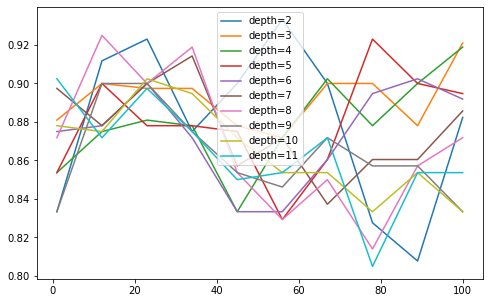

In [25]:
# смотрим результат

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

for i in range(scores1.shape[0]):
    plt.plot(np.linspace(1, 100, 10), scores1[i], label='depth=' + str(np.arange(2, 12)[i]))
plt.legend()

Заметим, что глубина = 2 достаточно норм предсказывает

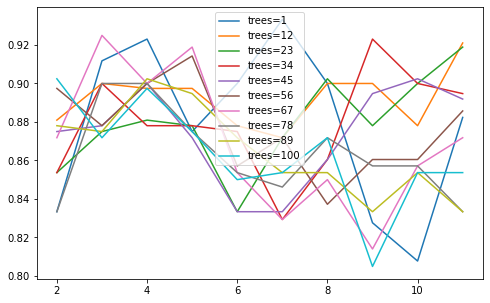

In [27]:
for i in range(scores1.shape[1]):
    plt.plot(np.arange(2, 12), scores1[i], label='trees=' + str(int(np.linspace(1, 100, 10)[i])))
plt.legend()

In [28]:
max_score = 0
best_depth = -1
best_n_estimators_count = -1

for n_trees in range(1, 201, 30): # используем разное кол-во деревьев
    for depth in range(1, 16): # используем разную глубину
        p = CatBoostClassifier(n_estimators=n_trees, max_depth=depth, task_type="GPU").fit(X_train, y_train).predict(X_test)
        score = precision_score(y_test, p)
        if max_score < score and score != 1:
            max_score = score
            best_depth = depth
            best_n_estimators_count = n_trees
            print('max_score:',max_score,'\t n_trees:', n_trees, 'depth:', depth)

Learning rate set to 0.5
0:	learn: 0.6022516	total: 4.09ms	remaining: 0us
max_score: 0.8333333333333334 	 n_trees: 1 depth: 1


Learning rate set to 0.5
0:	learn: 0.5879796	total: 4.21ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.5741065	total: 4.31ms	remaining: 0us
max_score: 0.9117647058823529 	 n_trees: 1 depth: 3
Learning rate set to 0.5
0:	learn: 0.5617805	total: 5.21ms	remaining: 0us
max_score: 0.9230769230769231 	 n_trees: 1 depth: 4
Learning rate set to 0.5
0:	learn: 0.5711749	total: 4.61ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.5785090	total: 11.7ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.5867025	total: 6.69ms	remaining: 0us
max_score: 0.9333333333333333 	 n_trees: 1 depth: 7
Learning rate set to 0.5
0:	learn: 0.6072151	total: 7.99ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.6197312	total: 13.7ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.6260667	total: 11.4ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.6385378	total: 14.9ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.6423856	total: 27.1ms	remaining: 0us
Learning rate set to 0.5
0:	le

9:	learn: 0.2952320	total: 50.5ms	remaining: 106ms
10:	learn: 0.2879020	total: 59.6ms	remaining: 108ms
11:	learn: 0.2793031	total: 64.9ms	remaining: 103ms
12:	learn: 0.2701371	total: 69.1ms	remaining: 95.7ms
13:	learn: 0.2622716	total: 72.9ms	remaining: 88.5ms
14:	learn: 0.2535787	total: 78.3ms	remaining: 83.5ms
15:	learn: 0.2479799	total: 87.5ms	remaining: 82ms
16:	learn: 0.2366938	total: 93ms	remaining: 76.6ms
17:	learn: 0.2284174	total: 96.7ms	remaining: 69.8ms
18:	learn: 0.2223141	total: 100ms	remaining: 63.4ms
19:	learn: 0.2144926	total: 106ms	remaining: 58.3ms
20:	learn: 0.2092329	total: 110ms	remaining: 52.5ms
21:	learn: 0.2029976	total: 120ms	remaining: 49.2ms
22:	learn: 0.1961269	total: 124ms	remaining: 43.2ms
23:	learn: 0.1912319	total: 128ms	remaining: 37.3ms
24:	learn: 0.1857186	total: 134ms	remaining: 32.1ms
25:	learn: 0.1826305	total: 138ms	remaining: 26.6ms
26:	learn: 0.1803451	total: 142ms	remaining: 21ms
27:	learn: 0.1779081	total: 152ms	remaining: 16.3ms
28:	learn: 0.

14:	learn: 0.2518219	total: 199ms	remaining: 212ms
15:	learn: 0.2397764	total: 216ms	remaining: 202ms
16:	learn: 0.2287431	total: 225ms	remaining: 185ms
17:	learn: 0.2197389	total: 236ms	remaining: 170ms
18:	learn: 0.2118051	total: 252ms	remaining: 159ms
19:	learn: 0.2036670	total: 263ms	remaining: 145ms
20:	learn: 0.1961642	total: 280ms	remaining: 133ms
21:	learn: 0.1891744	total: 290ms	remaining: 119ms
22:	learn: 0.1828092	total: 301ms	remaining: 105ms
23:	learn: 0.1759517	total: 317ms	remaining: 92.4ms
24:	learn: 0.1697948	total: 328ms	remaining: 78.7ms
25:	learn: 0.1642505	total: 345ms	remaining: 66.3ms
26:	learn: 0.1584787	total: 357ms	remaining: 52.9ms
27:	learn: 0.1538269	total: 369ms	remaining: 39.5ms
28:	learn: 0.1494049	total: 384ms	remaining: 26.5ms
29:	learn: 0.1442781	total: 395ms	remaining: 13.2ms
30:	learn: 0.1391822	total: 410ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.6385378	total: 15.5ms	remaining: 464ms
1:	learn: 0.5815150	total: 37.2ms	remaining: 539ms
2

19:	learn: 0.2307480	total: 1.88s	remaining: 1.03s
20:	learn: 0.2232919	total: 2s	remaining: 953ms
21:	learn: 0.2163292	total: 2.13s	remaining: 870ms
22:	learn: 0.2098326	total: 2.25s	remaining: 783ms
23:	learn: 0.2033423	total: 2.37s	remaining: 691ms
24:	learn: 0.1973733	total: 2.49s	remaining: 599ms
25:	learn: 0.1917613	total: 2.62s	remaining: 504ms
26:	learn: 0.1864521	total: 2.74s	remaining: 406ms
27:	learn: 0.1813978	total: 2.86s	remaining: 307ms
28:	learn: 0.1763986	total: 2.99s	remaining: 206ms
29:	learn: 0.1716579	total: 3.1s	remaining: 103ms
30:	learn: 0.1669921	total: 3.22s	remaining: 0us
Learning rate set to 0.448267
0:	learn: 0.6092535	total: 3.44ms	remaining: 207ms
1:	learn: 0.5566209	total: 6.6ms	remaining: 195ms
2:	learn: 0.5178661	total: 8.54ms	remaining: 165ms
3:	learn: 0.4890410	total: 10.4ms	remaining: 148ms
4:	learn: 0.4725651	total: 12.5ms	remaining: 140ms
5:	learn: 0.4553450	total: 14.2ms	remaining: 131ms
6:	learn: 0.4445410	total: 17.3ms	remaining: 133ms
7:	learn

42:	learn: 0.2221776	total: 185ms	remaining: 77.6ms
43:	learn: 0.2200578	total: 190ms	remaining: 73.3ms
44:	learn: 0.2185952	total: 193ms	remaining: 68.5ms
45:	learn: 0.2159118	total: 195ms	remaining: 63.7ms
46:	learn: 0.2146401	total: 198ms	remaining: 59.1ms
47:	learn: 0.2137754	total: 202ms	remaining: 54.8ms
48:	learn: 0.2116340	total: 205ms	remaining: 50.3ms
49:	learn: 0.2081160	total: 208ms	remaining: 45.8ms
50:	learn: 0.2027320	total: 211ms	remaining: 41.3ms
51:	learn: 0.1967824	total: 214ms	remaining: 37.1ms
52:	learn: 0.1910269	total: 217ms	remaining: 32.8ms
53:	learn: 0.1902189	total: 220ms	remaining: 28.5ms
54:	learn: 0.1873940	total: 223ms	remaining: 24.3ms
55:	learn: 0.1855327	total: 235ms	remaining: 21ms
56:	learn: 0.1830594	total: 238ms	remaining: 16.7ms
57:	learn: 0.1805565	total: 242ms	remaining: 12.5ms
58:	learn: 0.1784594	total: 245ms	remaining: 8.29ms
59:	learn: 0.1775279	total: 247ms	remaining: 4.12ms
60:	learn: 0.1763995	total: 252ms	remaining: 0us
Learning rate set

28:	learn: 0.1656575	total: 198ms	remaining: 218ms
29:	learn: 0.1602955	total: 202ms	remaining: 209ms
30:	learn: 0.1547957	total: 207ms	remaining: 200ms
31:	learn: 0.1524911	total: 213ms	remaining: 193ms
32:	learn: 0.1497279	total: 225ms	remaining: 191ms
33:	learn: 0.1451101	total: 230ms	remaining: 183ms
34:	learn: 0.1422645	total: 234ms	remaining: 174ms
35:	learn: 0.1393433	total: 240ms	remaining: 167ms
36:	learn: 0.1358210	total: 251ms	remaining: 163ms
37:	learn: 0.1322909	total: 256ms	remaining: 155ms
38:	learn: 0.1296771	total: 264ms	remaining: 149ms
39:	learn: 0.1258808	total: 269ms	remaining: 141ms
40:	learn: 0.1231143	total: 275ms	remaining: 134ms
41:	learn: 0.1202944	total: 287ms	remaining: 130ms
42:	learn: 0.1173492	total: 294ms	remaining: 123ms
43:	learn: 0.1153990	total: 299ms	remaining: 116ms
44:	learn: 0.1131280	total: 306ms	remaining: 109ms
45:	learn: 0.1113611	total: 317ms	remaining: 103ms
46:	learn: 0.1092766	total: 322ms	remaining: 95.9ms
47:	learn: 0.1065044	total: 32

17:	learn: 0.2218650	total: 196ms	remaining: 467ms
18:	learn: 0.2141553	total: 209ms	remaining: 462ms
19:	learn: 0.2067261	total: 217ms	remaining: 446ms
20:	learn: 0.1964980	total: 227ms	remaining: 432ms
21:	learn: 0.1888092	total: 243ms	remaining: 430ms
22:	learn: 0.1824845	total: 252ms	remaining: 416ms
23:	learn: 0.1759071	total: 260ms	remaining: 401ms
24:	learn: 0.1702409	total: 274ms	remaining: 394ms
25:	learn: 0.1651259	total: 281ms	remaining: 379ms
26:	learn: 0.1591750	total: 290ms	remaining: 366ms
27:	learn: 0.1546286	total: 301ms	remaining: 355ms
28:	learn: 0.1498443	total: 314ms	remaining: 346ms
29:	learn: 0.1436791	total: 321ms	remaining: 332ms
30:	learn: 0.1386878	total: 330ms	remaining: 319ms
31:	learn: 0.1344458	total: 345ms	remaining: 312ms
32:	learn: 0.1308599	total: 353ms	remaining: 300ms
33:	learn: 0.1278327	total: 364ms	remaining: 289ms
34:	learn: 0.1248985	total: 378ms	remaining: 281ms
35:	learn: 0.1213741	total: 387ms	remaining: 269ms
36:	learn: 0.1185202	total: 397

55:	learn: 0.0943742	total: 1s	remaining: 89.3ms
56:	learn: 0.0928293	total: 1.01s	remaining: 71.3ms
57:	learn: 0.0913527	total: 1.03s	remaining: 53.6ms
58:	learn: 0.0896603	total: 1.05s	remaining: 35.6ms
59:	learn: 0.0882460	total: 1.07s	remaining: 17.8ms
60:	learn: 0.0868412	total: 1.08s	remaining: 0us
Learning rate set to 0.448267
0:	learn: 0.6474657	total: 26ms	remaining: 1.56s
1:	learn: 0.5976657	total: 46.1ms	remaining: 1.36s
2:	learn: 0.5512608	total: 75.5ms	remaining: 1.46s
3:	learn: 0.5212975	total: 105ms	remaining: 1.49s
4:	learn: 0.4917942	total: 131ms	remaining: 1.47s
5:	learn: 0.4600140	total: 157ms	remaining: 1.44s
6:	learn: 0.4355796	total: 180ms	remaining: 1.38s
7:	learn: 0.4114371	total: 205ms	remaining: 1.36s
8:	learn: 0.3892945	total: 232ms	remaining: 1.34s
9:	learn: 0.3663581	total: 256ms	remaining: 1.3s
10:	learn: 0.3476140	total: 275ms	remaining: 1.25s
11:	learn: 0.3304615	total: 297ms	remaining: 1.21s
12:	learn: 0.3172821	total: 327ms	remaining: 1.21s
13:	learn: 

32:	learn: 0.1742856	total: 3.26s	remaining: 2.76s
33:	learn: 0.1701094	total: 3.36s	remaining: 2.67s
34:	learn: 0.1660618	total: 3.46s	remaining: 2.57s
35:	learn: 0.1620139	total: 3.56s	remaining: 2.47s
36:	learn: 0.1584215	total: 3.65s	remaining: 2.37s
37:	learn: 0.1548911	total: 3.75s	remaining: 2.27s
38:	learn: 0.1516624	total: 3.86s	remaining: 2.18s
39:	learn: 0.1484967	total: 3.97s	remaining: 2.08s
40:	learn: 0.1454698	total: 4.07s	remaining: 1.99s
41:	learn: 0.1424347	total: 4.18s	remaining: 1.89s
42:	learn: 0.1394617	total: 4.28s	remaining: 1.79s
43:	learn: 0.1366591	total: 4.38s	remaining: 1.69s
44:	learn: 0.1338870	total: 4.49s	remaining: 1.59s
45:	learn: 0.1311654	total: 4.59s	remaining: 1.5s
46:	learn: 0.1284318	total: 4.69s	remaining: 1.4s
47:	learn: 0.1261029	total: 4.79s	remaining: 1.3s
48:	learn: 0.1237921	total: 4.89s	remaining: 1.2s
49:	learn: 0.1214942	total: 5s	remaining: 1.1s
50:	learn: 0.1193351	total: 5.1s	remaining: 1s
51:	learn: 0.1171665	total: 5.19s	remaining

Learning rate set to 0.31325
0:	learn: 0.6208969	total: 3.6ms	remaining: 324ms
1:	learn: 0.5617927	total: 6.59ms	remaining: 293ms
2:	learn: 0.5190881	total: 10.3ms	remaining: 303ms
3:	learn: 0.4870809	total: 13.4ms	remaining: 291ms
4:	learn: 0.4653080	total: 18.3ms	remaining: 315ms
5:	learn: 0.4455976	total: 30.6ms	remaining: 433ms
6:	learn: 0.4309285	total: 33.1ms	remaining: 397ms
7:	learn: 0.4181906	total: 35.9ms	remaining: 373ms
8:	learn: 0.4063009	total: 38.2ms	remaining: 348ms
9:	learn: 0.3988760	total: 40.6ms	remaining: 329ms
10:	learn: 0.3903447	total: 43.1ms	remaining: 314ms
11:	learn: 0.3860149	total: 46.4ms	remaining: 306ms
12:	learn: 0.3836233	total: 58.1ms	remaining: 348ms
13:	learn: 0.3789472	total: 60.3ms	remaining: 332ms
14:	learn: 0.3735817	total: 62.9ms	remaining: 319ms
15:	learn: 0.3689014	total: 65.2ms	remaining: 305ms
16:	learn: 0.3648598	total: 67.4ms	remaining: 293ms
17:	learn: 0.3615044	total: 69.7ms	remaining: 282ms
18:	learn: 0.3586870	total: 71.9ms	remaining: 

Learning rate set to 0.31325
0:	learn: 0.6050047	total: 7.2ms	remaining: 648ms
1:	learn: 0.5406181	total: 20.1ms	remaining: 894ms
2:	learn: 0.4958632	total: 24.2ms	remaining: 709ms
3:	learn: 0.4590279	total: 28.7ms	remaining: 624ms
4:	learn: 0.4350879	total: 33.8ms	remaining: 581ms
5:	learn: 0.4152680	total: 47.9ms	remaining: 678ms
6:	learn: 0.3975823	total: 51.6ms	remaining: 619ms
7:	learn: 0.3817811	total: 56ms	remaining: 581ms
8:	learn: 0.3701825	total: 60.3ms	remaining: 549ms
9:	learn: 0.3585274	total: 65ms	remaining: 526ms
10:	learn: 0.3525719	total: 70.4ms	remaining: 512ms
11:	learn: 0.3445044	total: 83.8ms	remaining: 552ms
12:	learn: 0.3371624	total: 87.7ms	remaining: 526ms
13:	learn: 0.3303003	total: 91.3ms	remaining: 502ms
14:	learn: 0.3247475	total: 96.7ms	remaining: 490ms
15:	learn: 0.3209644	total: 103ms	remaining: 483ms
16:	learn: 0.3144199	total: 116ms	remaining: 505ms
17:	learn: 0.3072236	total: 120ms	remaining: 486ms
18:	learn: 0.3036744	total: 124ms	remaining: 470ms
19

73:	learn: 0.1242534	total: 1.17s	remaining: 269ms
74:	learn: 0.1225097	total: 1.19s	remaining: 253ms
75:	learn: 0.1216135	total: 1.21s	remaining: 239ms
76:	learn: 0.1205710	total: 1.24s	remaining: 225ms
77:	learn: 0.1192859	total: 1.25s	remaining: 209ms
78:	learn: 0.1173702	total: 1.27s	remaining: 192ms
79:	learn: 0.1160323	total: 1.28s	remaining: 176ms
80:	learn: 0.1154478	total: 1.31s	remaining: 162ms
81:	learn: 0.1138276	total: 1.33s	remaining: 146ms
82:	learn: 0.1123786	total: 1.35s	remaining: 130ms
83:	learn: 0.1118448	total: 1.36s	remaining: 114ms
84:	learn: 0.1105345	total: 1.39s	remaining: 98.1ms
85:	learn: 0.1092943	total: 1.4s	remaining: 81.6ms
86:	learn: 0.1085876	total: 1.43s	remaining: 65.7ms
87:	learn: 0.1072060	total: 1.44s	remaining: 49.2ms
88:	learn: 0.1060935	total: 1.46s	remaining: 32.8ms
89:	learn: 0.1053956	total: 1.48s	remaining: 16.5ms
90:	learn: 0.1049965	total: 1.5s	remaining: 0us
Learning rate set to 0.31325
0:	learn: 0.6171541	total: 23.4ms	remaining: 2.11s


53:	learn: 0.1213467	total: 1.16s	remaining: 795ms
54:	learn: 0.1186426	total: 1.19s	remaining: 776ms
55:	learn: 0.1169185	total: 1.2s	remaining: 751ms
56:	learn: 0.1148815	total: 1.23s	remaining: 731ms
57:	learn: 0.1132346	total: 1.24s	remaining: 707ms
58:	learn: 0.1109125	total: 1.26s	remaining: 685ms
59:	learn: 0.1098036	total: 1.28s	remaining: 662ms
60:	learn: 0.1076732	total: 1.3s	remaining: 638ms
61:	learn: 0.1063672	total: 1.32s	remaining: 619ms
62:	learn: 0.1051564	total: 1.34s	remaining: 595ms
63:	learn: 0.1033073	total: 1.36s	remaining: 575ms
64:	learn: 0.1020615	total: 1.38s	remaining: 552ms
65:	learn: 0.1001696	total: 1.4s	remaining: 532ms
66:	learn: 0.0988257	total: 1.42s	remaining: 508ms
67:	learn: 0.0973154	total: 1.43s	remaining: 485ms
68:	learn: 0.0954120	total: 1.47s	remaining: 469ms
69:	learn: 0.0942134	total: 1.5s	remaining: 450ms
70:	learn: 0.0926878	total: 1.53s	remaining: 430ms
71:	learn: 0.0916398	total: 1.56s	remaining: 411ms
72:	learn: 0.0903017	total: 1.6s	re

0:	learn: 0.6373323	total: 29.4ms	remaining: 2.65s
1:	learn: 0.5850264	total: 64.5ms	remaining: 2.87s
2:	learn: 0.5441535	total: 81.7ms	remaining: 2.4s
3:	learn: 0.5110652	total: 113ms	remaining: 2.45s
4:	learn: 0.4777870	total: 150ms	remaining: 2.57s
5:	learn: 0.4506636	total: 167ms	remaining: 2.36s
6:	learn: 0.4286871	total: 192ms	remaining: 2.3s
7:	learn: 0.4056374	total: 218ms	remaining: 2.26s
8:	learn: 0.3859849	total: 246ms	remaining: 2.24s
9:	learn: 0.3673964	total: 263ms	remaining: 2.13s
10:	learn: 0.3519414	total: 288ms	remaining: 2.1s
11:	learn: 0.3373153	total: 304ms	remaining: 2s
12:	learn: 0.3263942	total: 329ms	remaining: 1.97s
13:	learn: 0.3137954	total: 357ms	remaining: 1.96s
14:	learn: 0.3039181	total: 373ms	remaining: 1.89s
15:	learn: 0.2939021	total: 399ms	remaining: 1.87s
16:	learn: 0.2829568	total: 423ms	remaining: 1.84s
17:	learn: 0.2738110	total: 440ms	remaining: 1.78s
18:	learn: 0.2655238	total: 466ms	remaining: 1.77s
19:	learn: 0.2569962	total: 492ms	remaining:

3:	learn: 0.5185227	total: 136ms	remaining: 2.96s
4:	learn: 0.4900322	total: 166ms	remaining: 2.86s
5:	learn: 0.4652326	total: 194ms	remaining: 2.75s
6:	learn: 0.4354093	total: 231ms	remaining: 2.77s
7:	learn: 0.4094412	total: 259ms	remaining: 2.69s
8:	learn: 0.3924844	total: 287ms	remaining: 2.61s
9:	learn: 0.3779771	total: 314ms	remaining: 2.54s
10:	learn: 0.3613610	total: 343ms	remaining: 2.49s
11:	learn: 0.3482760	total: 371ms	remaining: 2.44s
12:	learn: 0.3372910	total: 409ms	remaining: 2.46s
13:	learn: 0.3250336	total: 437ms	remaining: 2.4s
14:	learn: 0.3142429	total: 454ms	remaining: 2.3s
15:	learn: 0.3047994	total: 481ms	remaining: 2.25s
16:	learn: 0.2941695	total: 508ms	remaining: 2.21s
17:	learn: 0.2842477	total: 538ms	remaining: 2.18s
18:	learn: 0.2757172	total: 564ms	remaining: 2.13s
19:	learn: 0.2675609	total: 591ms	remaining: 2.1s
20:	learn: 0.2590768	total: 618ms	remaining: 2.06s
21:	learn: 0.2508353	total: 646ms	remaining: 2.03s
22:	learn: 0.2436158	total: 685ms	remaini

3:	learn: 0.5410689	total: 182ms	remaining: 3.96s
4:	learn: 0.5180579	total: 223ms	remaining: 3.84s
5:	learn: 0.4948118	total: 264ms	remaining: 3.73s
6:	learn: 0.4670281	total: 302ms	remaining: 3.63s
7:	learn: 0.4461354	total: 335ms	remaining: 3.47s
8:	learn: 0.4266843	total: 375ms	remaining: 3.41s
9:	learn: 0.4082759	total: 415ms	remaining: 3.36s
10:	learn: 0.3945071	total: 446ms	remaining: 3.24s
11:	learn: 0.3791534	total: 487ms	remaining: 3.2s
12:	learn: 0.3634793	total: 526ms	remaining: 3.15s
13:	learn: 0.3483135	total: 555ms	remaining: 3.05s
14:	learn: 0.3375738	total: 594ms	remaining: 3.01s
15:	learn: 0.3267757	total: 623ms	remaining: 2.92s
16:	learn: 0.3159352	total: 663ms	remaining: 2.88s
17:	learn: 0.3057785	total: 693ms	remaining: 2.81s
18:	learn: 0.2952231	total: 732ms	remaining: 2.77s
19:	learn: 0.2864541	total: 762ms	remaining: 2.71s
20:	learn: 0.2786397	total: 801ms	remaining: 2.67s
21:	learn: 0.2692799	total: 831ms	remaining: 2.6s
22:	learn: 0.2611837	total: 871ms	remain

76:	learn: 0.0971704	total: 4.6s	remaining: 836ms
77:	learn: 0.0960276	total: 4.68s	remaining: 781ms
78:	learn: 0.0949425	total: 4.77s	remaining: 724ms
79:	learn: 0.0937497	total: 4.85s	remaining: 667ms
80:	learn: 0.0926307	total: 4.93s	remaining: 608ms
81:	learn: 0.0915864	total: 5.01s	remaining: 550ms
82:	learn: 0.0904148	total: 5.09s	remaining: 491ms
83:	learn: 0.0893619	total: 5.17s	remaining: 431ms
84:	learn: 0.0883340	total: 5.26s	remaining: 371ms
85:	learn: 0.0872655	total: 5.34s	remaining: 310ms
86:	learn: 0.0862746	total: 5.42s	remaining: 249ms
87:	learn: 0.0851443	total: 5.5s	remaining: 188ms
88:	learn: 0.0841215	total: 5.58s	remaining: 126ms
89:	learn: 0.0831185	total: 5.67s	remaining: 63ms
90:	learn: 0.0822502	total: 5.75s	remaining: 0us
Learning rate set to 0.31325
0:	learn: 0.6609107	total: 24.9ms	remaining: 2.24s
1:	learn: 0.6244266	total: 46.8ms	remaining: 2.08s
2:	learn: 0.5889864	total: 69.6ms	remaining: 2.04s
3:	learn: 0.5553830	total: 78.1ms	remaining: 1.7s
4:	learn

59:	learn: 0.1399066	total: 2.16s	remaining: 1.11s
60:	learn: 0.1378890	total: 2.2s	remaining: 1.08s
61:	learn: 0.1357949	total: 2.23s	remaining: 1.04s
62:	learn: 0.1338419	total: 2.27s	remaining: 1.01s
63:	learn: 0.1318411	total: 2.31s	remaining: 973ms
64:	learn: 0.1299789	total: 2.34s	remaining: 938ms
65:	learn: 0.1281625	total: 2.38s	remaining: 903ms
66:	learn: 0.1264967	total: 2.42s	remaining: 867ms
67:	learn: 0.1248499	total: 2.46s	remaining: 831ms
68:	learn: 0.1229969	total: 2.5s	remaining: 796ms
69:	learn: 0.1213557	total: 2.53s	remaining: 760ms
70:	learn: 0.1197631	total: 2.57s	remaining: 724ms
71:	learn: 0.1182110	total: 2.61s	remaining: 688ms
72:	learn: 0.1167299	total: 2.64s	remaining: 652ms
73:	learn: 0.1152813	total: 2.68s	remaining: 616ms
74:	learn: 0.1138658	total: 2.72s	remaining: 580ms
75:	learn: 0.1124289	total: 2.75s	remaining: 544ms
76:	learn: 0.1111030	total: 2.79s	remaining: 508ms
77:	learn: 0.1096301	total: 2.83s	remaining: 471ms
78:	learn: 0.1083708	total: 2.86s

0:	learn: 0.6673122	total: 207ms	remaining: 18.6s
1:	learn: 0.5925947	total: 277ms	remaining: 12.3s
2:	learn: 0.5687554	total: 467ms	remaining: 13.7s
3:	learn: 0.5463618	total: 607ms	remaining: 13.2s
4:	learn: 0.5252139	total: 820ms	remaining: 14.1s
5:	learn: 0.5041812	total: 1.02s	remaining: 14.5s
6:	learn: 0.4857474	total: 1.23s	remaining: 14.8s
7:	learn: 0.4687023	total: 1.44s	remaining: 14.9s
8:	learn: 0.4526519	total: 1.66s	remaining: 15.1s
9:	learn: 0.4378031	total: 1.86s	remaining: 15.1s
10:	learn: 0.4209100	total: 1.98s	remaining: 14.4s
11:	learn: 0.4046361	total: 2.11s	remaining: 13.9s
12:	learn: 0.3900815	total: 2.22s	remaining: 13.3s
13:	learn: 0.3781351	total: 2.34s	remaining: 12.9s
14:	learn: 0.3662095	total: 2.55s	remaining: 12.9s
15:	learn: 0.3560661	total: 2.73s	remaining: 12.8s
16:	learn: 0.3452671	total: 2.93s	remaining: 12.8s
17:	learn: 0.3354381	total: 3.07s	remaining: 12.5s
18:	learn: 0.3258202	total: 3.27s	remaining: 12.4s
19:	learn: 0.3154743	total: 3.42s	remaini

81:	learn: 0.3360422	total: 752ms	remaining: 358ms
82:	learn: 0.3359695	total: 754ms	remaining: 345ms
83:	learn: 0.3355133	total: 766ms	remaining: 337ms
84:	learn: 0.3351903	total: 778ms	remaining: 330ms
85:	learn: 0.3342590	total: 781ms	remaining: 318ms
86:	learn: 0.3342010	total: 793ms	remaining: 310ms
87:	learn: 0.3336698	total: 805ms	remaining: 302ms
88:	learn: 0.3326431	total: 807ms	remaining: 290ms
89:	learn: 0.3319102	total: 820ms	remaining: 282ms
90:	learn: 0.3316242	total: 822ms	remaining: 271ms
91:	learn: 0.3310379	total: 833ms	remaining: 263ms
92:	learn: 0.3305522	total: 838ms	remaining: 252ms
93:	learn: 0.3297920	total: 859ms	remaining: 247ms
94:	learn: 0.3294068	total: 861ms	remaining: 236ms
95:	learn: 0.3287346	total: 873ms	remaining: 227ms
96:	learn: 0.3280770	total: 886ms	remaining: 219ms
97:	learn: 0.3280361	total: 899ms	remaining: 211ms
98:	learn: 0.3271672	total: 901ms	remaining: 200ms
99:	learn: 0.3265484	total: 914ms	remaining: 192ms
100:	learn: 0.3259496	total: 92

Learning rate set to 0.24267
0:	learn: 0.6287137	total: 13.7ms	remaining: 1.64s
1:	learn: 0.5757535	total: 27.3ms	remaining: 1.63s
2:	learn: 0.5335745	total: 40.9ms	remaining: 1.61s
3:	learn: 0.5074171	total: 54.4ms	remaining: 1.59s
4:	learn: 0.4821233	total: 68.5ms	remaining: 1.59s
5:	learn: 0.4597487	total: 81.8ms	remaining: 1.57s
6:	learn: 0.4431740	total: 95.2ms	remaining: 1.55s
7:	learn: 0.4267579	total: 108ms	remaining: 1.53s
8:	learn: 0.4192717	total: 122ms	remaining: 1.52s


9:	learn: 0.4068277	total: 135ms	remaining: 1.5s
10:	learn: 0.3970881	total: 148ms	remaining: 1.48s
11:	learn: 0.3889656	total: 162ms	remaining: 1.47s
12:	learn: 0.3829942	total: 169ms	remaining: 1.4s
13:	learn: 0.3785660	total: 178ms	remaining: 1.36s
14:	learn: 0.3739612	total: 190ms	remaining: 1.35s
15:	learn: 0.3699651	total: 203ms	remaining: 1.33s
16:	learn: 0.3611658	total: 216ms	remaining: 1.32s
17:	learn: 0.3562891	total: 230ms	remaining: 1.31s
18:	learn: 0.3511299	total: 243ms	remaining: 1.31s
19:	learn: 0.3454415	total: 250ms	remaining: 1.26s
20:	learn: 0.3403561	total: 259ms	remaining: 1.23s
21:	learn: 0.3371623	total: 271ms	remaining: 1.22s
22:	learn: 0.3328399	total: 285ms	remaining: 1.21s
23:	learn: 0.3265642	total: 298ms	remaining: 1.21s
24:	learn: 0.3244271	total: 312ms	remaining: 1.2s
25:	learn: 0.3216494	total: 326ms	remaining: 1.19s
26:	learn: 0.3190589	total: 339ms	remaining: 1.18s
27:	learn: 0.3160525	total: 352ms	remaining: 1.17s
28:	learn: 0.3127115	total: 366ms	r

8:	learn: 0.4017264	total: 138ms	remaining: 1.71s
9:	learn: 0.3895812	total: 151ms	remaining: 1.67s
10:	learn: 0.3801353	total: 165ms	remaining: 1.65s
11:	learn: 0.3720490	total: 183ms	remaining: 1.67s
12:	learn: 0.3612128	total: 203ms	remaining: 1.68s
13:	learn: 0.3559598	total: 217ms	remaining: 1.66s
14:	learn: 0.3494329	total: 231ms	remaining: 1.63s
15:	learn: 0.3401025	total: 245ms	remaining: 1.61s
16:	learn: 0.3325625	total: 259ms	remaining: 1.58s
17:	learn: 0.3278415	total: 272ms	remaining: 1.56s
18:	learn: 0.3237183	total: 286ms	remaining: 1.53s
19:	learn: 0.3194556	total: 300ms	remaining: 1.51s
20:	learn: 0.3155638	total: 314ms	remaining: 1.49s
21:	learn: 0.3128172	total: 328ms	remaining: 1.48s
22:	learn: 0.3088146	total: 341ms	remaining: 1.45s
23:	learn: 0.3024478	total: 364ms	remaining: 1.47s
24:	learn: 0.2992256	total: 380ms	remaining: 1.46s
25:	learn: 0.2964582	total: 394ms	remaining: 1.44s
26:	learn: 0.2910890	total: 408ms	remaining: 1.42s
27:	learn: 0.2859053	total: 422ms

53:	learn: 0.1897014	total: 969ms	remaining: 1.2s
54:	learn: 0.1879793	total: 983ms	remaining: 1.18s
55:	learn: 0.1868488	total: 998ms	remaining: 1.16s
56:	learn: 0.1848733	total: 1.01s	remaining: 1.14s
57:	learn: 0.1833316	total: 1.04s	remaining: 1.13s
58:	learn: 0.1820286	total: 1.05s	remaining: 1.1s
59:	learn: 0.1814229	total: 1.07s	remaining: 1.08s
60:	learn: 0.1794495	total: 1.09s	remaining: 1.07s
61:	learn: 0.1785601	total: 1.1s	remaining: 1.05s
62:	learn: 0.1775369	total: 1.12s	remaining: 1.03s
63:	learn: 0.1749645	total: 1.15s	remaining: 1.02s
64:	learn: 0.1741567	total: 1.16s	remaining: 999ms
65:	learn: 0.1727793	total: 1.17s	remaining: 978ms
66:	learn: 0.1697229	total: 1.19s	remaining: 958ms
67:	learn: 0.1685611	total: 1.21s	remaining: 946ms
68:	learn: 0.1667808	total: 1.23s	remaining: 925ms
69:	learn: 0.1639069	total: 1.24s	remaining: 905ms
70:	learn: 0.1633215	total: 1.26s	remaining: 885ms
71:	learn: 0.1626058	total: 1.27s	remaining: 867ms
72:	learn: 0.1617440	total: 1.29s	

96:	learn: 0.0996827	total: 1.95s	remaining: 483ms
97:	learn: 0.0987684	total: 1.97s	remaining: 461ms
98:	learn: 0.0975326	total: 1.99s	remaining: 443ms
99:	learn: 0.0962636	total: 2.01s	remaining: 421ms
100:	learn: 0.0957694	total: 2.02s	remaining: 400ms
101:	learn: 0.0952800	total: 2.05s	remaining: 381ms
102:	learn: 0.0941392	total: 2.06s	remaining: 360ms
103:	learn: 0.0935831	total: 2.08s	remaining: 339ms
104:	learn: 0.0924708	total: 2.1s	remaining: 320ms
105:	learn: 0.0918237	total: 2.12s	remaining: 300ms
106:	learn: 0.0912382	total: 2.14s	remaining: 280ms
107:	learn: 0.0905877	total: 2.16s	remaining: 260ms
108:	learn: 0.0901599	total: 2.17s	remaining: 239ms
109:	learn: 0.0889395	total: 2.2s	remaining: 220ms
110:	learn: 0.0879845	total: 2.21s	remaining: 199ms
111:	learn: 0.0874586	total: 2.24s	remaining: 180ms
112:	learn: 0.0867313	total: 2.25s	remaining: 160ms
113:	learn: 0.0858093	total: 2.28s	remaining: 140ms
114:	learn: 0.0849271	total: 2.29s	remaining: 120ms
115:	learn: 0.0842

6:	learn: 0.4506518	total: 164ms	remaining: 2.67s
7:	learn: 0.4297043	total: 191ms	remaining: 2.69s
8:	learn: 0.4074381	total: 206ms	remaining: 2.57s
9:	learn: 0.3915468	total: 232ms	remaining: 2.58s
10:	learn: 0.3778022	total: 249ms	remaining: 2.49s
11:	learn: 0.3654043	total: 274ms	remaining: 2.48s
12:	learn: 0.3489168	total: 300ms	remaining: 2.49s
13:	learn: 0.3369633	total: 316ms	remaining: 2.42s
14:	learn: 0.3276276	total: 343ms	remaining: 2.42s
15:	learn: 0.3182697	total: 370ms	remaining: 2.43s
16:	learn: 0.3105200	total: 397ms	remaining: 2.43s
17:	learn: 0.3032832	total: 425ms	remaining: 2.43s
18:	learn: 0.2975902	total: 452ms	remaining: 2.43s
19:	learn: 0.2903372	total: 479ms	remaining: 2.42s
20:	learn: 0.2829247	total: 507ms	remaining: 2.41s
21:	learn: 0.2760086	total: 531ms	remaining: 2.39s
22:	learn: 0.2689836	total: 549ms	remaining: 2.34s
23:	learn: 0.2624133	total: 576ms	remaining: 2.33s
24:	learn: 0.2563675	total: 604ms	remaining: 2.32s
25:	learn: 0.2493114	total: 631ms	r

50:	learn: 0.1515812	total: 1.23s	remaining: 1.69s
51:	learn: 0.1488656	total: 1.26s	remaining: 1.67s
52:	learn: 0.1466898	total: 1.29s	remaining: 1.65s
53:	learn: 0.1443161	total: 1.3s	remaining: 1.62s
54:	learn: 0.1414993	total: 1.33s	remaining: 1.59s
55:	learn: 0.1388997	total: 1.35s	remaining: 1.57s
56:	learn: 0.1370777	total: 1.38s	remaining: 1.55s
57:	learn: 0.1350203	total: 1.41s	remaining: 1.53s
58:	learn: 0.1330875	total: 1.43s	remaining: 1.5s
59:	learn: 0.1307261	total: 1.45s	remaining: 1.48s
60:	learn: 0.1288760	total: 1.48s	remaining: 1.46s
61:	learn: 0.1270657	total: 1.51s	remaining: 1.43s
62:	learn: 0.1251096	total: 1.53s	remaining: 1.41s
63:	learn: 0.1235655	total: 1.56s	remaining: 1.39s
64:	learn: 0.1217823	total: 1.59s	remaining: 1.37s
65:	learn: 0.1199646	total: 1.62s	remaining: 1.35s
66:	learn: 0.1183326	total: 1.64s	remaining: 1.32s
67:	learn: 0.1167710	total: 1.67s	remaining: 1.3s
68:	learn: 0.1150563	total: 1.7s	remaining: 1.28s
69:	learn: 0.1137135	total: 1.73s	r

93:	learn: 0.0884626	total: 2.87s	remaining: 824ms
94:	learn: 0.0876223	total: 2.9s	remaining: 793ms
95:	learn: 0.0866707	total: 2.94s	remaining: 764ms
96:	learn: 0.0856595	total: 2.96s	remaining: 733ms
97:	learn: 0.0844570	total: 2.99s	remaining: 702ms
98:	learn: 0.0833906	total: 3.02s	remaining: 671ms
99:	learn: 0.0826312	total: 3.05s	remaining: 640ms
100:	learn: 0.0818165	total: 3.08s	remaining: 609ms
101:	learn: 0.0809052	total: 3.1s	remaining: 578ms
102:	learn: 0.0801196	total: 3.13s	remaining: 547ms
103:	learn: 0.0792692	total: 3.16s	remaining: 516ms
104:	learn: 0.0783390	total: 3.18s	remaining: 485ms
105:	learn: 0.0776538	total: 3.21s	remaining: 455ms
106:	learn: 0.0769555	total: 3.25s	remaining: 426ms
107:	learn: 0.0762986	total: 3.28s	remaining: 395ms
108:	learn: 0.0755323	total: 3.31s	remaining: 364ms
109:	learn: 0.0748761	total: 3.35s	remaining: 335ms
110:	learn: 0.0741343	total: 3.38s	remaining: 304ms
111:	learn: 0.0734454	total: 3.4s	remaining: 274ms
112:	learn: 0.0727736	

3:	learn: 0.5699709	total: 165ms	remaining: 4.83s
4:	learn: 0.5475783	total: 206ms	remaining: 4.77s
5:	learn: 0.5276300	total: 240ms	remaining: 4.6s
6:	learn: 0.5061828	total: 276ms	remaining: 4.5s
7:	learn: 0.4855030	total: 317ms	remaining: 4.48s
8:	learn: 0.4674084	total: 358ms	remaining: 4.45s
9:	learn: 0.4476847	total: 395ms	remaining: 4.38s
10:	learn: 0.4351517	total: 428ms	remaining: 4.28s
11:	learn: 0.4209765	total: 469ms	remaining: 4.26s
12:	learn: 0.4061717	total: 510ms	remaining: 4.24s
13:	learn: 0.3943273	total: 551ms	remaining: 4.21s
14:	learn: 0.3839732	total: 591ms	remaining: 4.18s
15:	learn: 0.3703697	total: 632ms	remaining: 4.15s
16:	learn: 0.3597712	total: 662ms	remaining: 4.05s
17:	learn: 0.3500200	total: 703ms	remaining: 4.02s
18:	learn: 0.3410192	total: 742ms	remaining: 3.98s
19:	learn: 0.3322710	total: 772ms	remaining: 3.9s
20:	learn: 0.3235249	total: 812ms	remaining: 3.87s
21:	learn: 0.3147056	total: 853ms	remaining: 3.84s
22:	learn: 0.3070718	total: 889ms	remaini

46:	learn: 0.1885108	total: 2.39s	remaining: 3.76s
47:	learn: 0.1854587	total: 2.43s	remaining: 3.69s
48:	learn: 0.1825915	total: 2.48s	remaining: 3.65s
49:	learn: 0.1796035	total: 2.52s	remaining: 3.58s
50:	learn: 0.1769011	total: 2.58s	remaining: 3.54s
51:	learn: 0.1740996	total: 2.63s	remaining: 3.48s
52:	learn: 0.1714055	total: 2.68s	remaining: 3.43s
53:	learn: 0.1689721	total: 2.73s	remaining: 3.38s
54:	learn: 0.1665335	total: 2.77s	remaining: 3.33s
55:	learn: 0.1640800	total: 2.82s	remaining: 3.27s
56:	learn: 0.1617529	total: 2.87s	remaining: 3.22s
57:	learn: 0.1595031	total: 2.92s	remaining: 3.17s
58:	learn: 0.1572581	total: 2.97s	remaining: 3.12s
59:	learn: 0.1550700	total: 3.02s	remaining: 3.07s
60:	learn: 0.1526898	total: 3.06s	remaining: 3.01s
61:	learn: 0.1504822	total: 3.12s	remaining: 2.96s
62:	learn: 0.1483540	total: 3.16s	remaining: 2.91s
63:	learn: 0.1463226	total: 3.21s	remaining: 2.86s
64:	learn: 0.1444320	total: 3.25s	remaining: 2.8s
65:	learn: 0.1425687	total: 3.3s

88:	learn: 0.1153458	total: 6.82s	remaining: 2.45s
89:	learn: 0.1139565	total: 6.89s	remaining: 2.37s
90:	learn: 0.1128334	total: 6.96s	remaining: 2.29s
91:	learn: 0.1117436	total: 7.03s	remaining: 2.21s
92:	learn: 0.1107080	total: 7.1s	remaining: 2.14s
93:	learn: 0.1096137	total: 7.17s	remaining: 2.06s
94:	learn: 0.1084908	total: 7.23s	remaining: 1.98s
95:	learn: 0.1074326	total: 7.3s	remaining: 1.9s
96:	learn: 0.1063359	total: 7.38s	remaining: 1.82s
97:	learn: 0.1053147	total: 7.46s	remaining: 1.75s
98:	learn: 0.1043488	total: 7.51s	remaining: 1.67s
99:	learn: 0.1033974	total: 7.58s	remaining: 1.59s
100:	learn: 0.1024863	total: 7.65s	remaining: 1.51s
101:	learn: 0.1015431	total: 7.72s	remaining: 1.44s
102:	learn: 0.1005507	total: 7.79s	remaining: 1.36s
103:	learn: 0.0996304	total: 7.86s	remaining: 1.28s
104:	learn: 0.0986904	total: 7.92s	remaining: 1.21s
105:	learn: 0.0977936	total: 7.98s	remaining: 1.13s
106:	learn: 0.0968571	total: 8.05s	remaining: 1.05s
107:	learn: 0.0960212	total

6:	learn: 0.5225583	total: 841ms	remaining: 13.7s
7:	learn: 0.5074918	total: 981ms	remaining: 13.9s
8:	learn: 0.4945868	total: 1.12s	remaining: 14s
9:	learn: 0.4809230	total: 1.25s	remaining: 13.9s
10:	learn: 0.4603804	total: 1.31s	remaining: 13.1s
11:	learn: 0.4434884	total: 1.39s	remaining: 12.7s
12:	learn: 0.4281440	total: 1.42s	remaining: 11.8s
13:	learn: 0.4161052	total: 1.5s	remaining: 11.5s
14:	learn: 0.4028114	total: 1.56s	remaining: 11s
15:	learn: 0.3933491	total: 1.67s	remaining: 10.9s
16:	learn: 0.3822727	total: 2.07s	remaining: 12.7s
17:	learn: 0.3735740	total: 2.73s	remaining: 15.6s
18:	learn: 0.3653866	total: 3.4s	remaining: 18.2s
19:	learn: 0.3574483	total: 4.07s	remaining: 20.5s
20:	learn: 0.3493038	total: 4.73s	remaining: 22.5s
21:	learn: 0.3410785	total: 5.38s	remaining: 24.2s
22:	learn: 0.3323783	total: 5.76s	remaining: 24.5s
23:	learn: 0.3254106	total: 6.42s	remaining: 25.9s
24:	learn: 0.3187202	total: 7.08s	remaining: 27.2s
25:	learn: 0.3120908	total: 7.75s	remaini

48:	learn: 0.2088194	total: 9.19s	remaining: 13.5s
49:	learn: 0.2057523	total: 9.38s	remaining: 13.3s
50:	learn: 0.2028436	total: 9.58s	remaining: 13.2s
51:	learn: 0.1999440	total: 9.8s	remaining: 13s
52:	learn: 0.1969133	total: 10s	remaining: 12.8s
53:	learn: 0.1941061	total: 10.2s	remaining: 12.7s
54:	learn: 0.1914509	total: 10.4s	remaining: 12.5s
55:	learn: 0.1887407	total: 10.6s	remaining: 12.3s
56:	learn: 0.1861640	total: 10.9s	remaining: 12.2s
57:	learn: 0.1836139	total: 11.1s	remaining: 12s
58:	learn: 0.1811855	total: 11.3s	remaining: 11.8s
59:	learn: 0.1786710	total: 11.5s	remaining: 11.7s
60:	learn: 0.1764073	total: 11.7s	remaining: 11.5s
61:	learn: 0.1741247	total: 11.9s	remaining: 11.3s
62:	learn: 0.1718072	total: 12.1s	remaining: 11.1s
63:	learn: 0.1695989	total: 12.3s	remaining: 11s
64:	learn: 0.1674829	total: 12.5s	remaining: 10.8s
65:	learn: 0.1653821	total: 12.7s	remaining: 10.6s
66:	learn: 0.1634605	total: 12.9s	remaining: 10.4s
67:	learn: 0.1614284	total: 13.1s	remain

103:	learn: 0.3339919	total: 953ms	remaining: 431ms
104:	learn: 0.3332663	total: 955ms	remaining: 418ms
105:	learn: 0.3329721	total: 967ms	remaining: 411ms
106:	learn: 0.3327392	total: 980ms	remaining: 403ms
107:	learn: 0.3325113	total: 982ms	remaining: 391ms
108:	learn: 0.3323133	total: 994ms	remaining: 383ms
109:	learn: 0.3317872	total: 995ms	remaining: 371ms
110:	learn: 0.3316370	total: 1.01s	remaining: 363ms
111:	learn: 0.3311779	total: 1.02s	remaining: 355ms
112:	learn: 0.3307477	total: 1.02s	remaining: 344ms
113:	learn: 0.3303529	total: 1.03s	remaining: 336ms
114:	learn: 0.3299681	total: 1.04s	remaining: 324ms
115:	learn: 0.3296924	total: 1.05s	remaining: 316ms
116:	learn: 0.3294738	total: 1.06s	remaining: 308ms
117:	learn: 0.3291796	total: 1.06s	remaining: 297ms
118:	learn: 0.3285952	total: 1.07s	remaining: 289ms
119:	learn: 0.3281234	total: 1.08s	remaining: 278ms
120:	learn: 0.3278947	total: 1.09s	remaining: 270ms
121:	learn: 0.3275104	total: 1.1s	remaining: 262ms
122:	learn: 0

115:	learn: 0.2612247	total: 1.29s	remaining: 391ms
116:	learn: 0.2610384	total: 1.31s	remaining: 380ms
117:	learn: 0.2608943	total: 1.32s	remaining: 370ms
118:	learn: 0.2605043	total: 1.33s	remaining: 359ms
119:	learn: 0.2601217	total: 1.35s	remaining: 349ms
120:	learn: 0.2594539	total: 1.36s	remaining: 338ms
121:	learn: 0.2575481	total: 1.38s	remaining: 327ms
122:	learn: 0.2572476	total: 1.39s	remaining: 316ms
123:	learn: 0.2570316	total: 1.4s	remaining: 306ms
124:	learn: 0.2564201	total: 1.42s	remaining: 295ms
125:	learn: 0.2545529	total: 1.43s	remaining: 284ms
126:	learn: 0.2540239	total: 1.43s	remaining: 271ms
127:	learn: 0.2536847	total: 1.45s	remaining: 260ms
128:	learn: 0.2534323	total: 1.46s	remaining: 249ms
129:	learn: 0.2532870	total: 1.47s	remaining: 238ms
130:	learn: 0.2529547	total: 1.48s	remaining: 227ms
131:	learn: 0.2520873	total: 1.5s	remaining: 216ms
132:	learn: 0.2514768	total: 1.51s	remaining: 205ms
133:	learn: 0.2508511	total: 1.53s	remaining: 194ms
134:	learn: 0.

128:	learn: 0.1859846	total: 1.69s	remaining: 288ms
129:	learn: 0.1850905	total: 1.7s	remaining: 275ms
130:	learn: 0.1848080	total: 1.71s	remaining: 262ms
131:	learn: 0.1840409	total: 1.73s	remaining: 249ms
132:	learn: 0.1835499	total: 1.74s	remaining: 236ms
133:	learn: 0.1825131	total: 1.75s	remaining: 222ms
134:	learn: 0.1819105	total: 1.77s	remaining: 209ms
135:	learn: 0.1809966	total: 1.78s	remaining: 196ms
136:	learn: 0.1807630	total: 1.79s	remaining: 183ms
137:	learn: 0.1799160	total: 1.81s	remaining: 170ms
138:	learn: 0.1793738	total: 1.82s	remaining: 157ms
139:	learn: 0.1790260	total: 1.83s	remaining: 144ms
140:	learn: 0.1788187	total: 1.84s	remaining: 130ms
141:	learn: 0.1782599	total: 1.85s	remaining: 117ms
142:	learn: 0.1778951	total: 1.86s	remaining: 104ms
143:	learn: 0.1762991	total: 1.88s	remaining: 91.2ms
144:	learn: 0.1756956	total: 1.89s	remaining: 78.2ms
145:	learn: 0.1752496	total: 1.9s	remaining: 65.2ms
146:	learn: 0.1747969	total: 1.92s	remaining: 52.1ms
147:	learn

Learning rate set to 0.198989
0:	learn: 0.6397934	total: 6.68ms	remaining: 1s
1:	learn: 0.5958956	total: 21.3ms	remaining: 1.58s
2:	learn: 0.5614825	total: 25.4ms	remaining: 1.25s
3:	learn: 0.5290417	total: 30.5ms	remaining: 1.12s
4:	learn: 0.5078248	total: 35.2ms	remaining: 1.03s
5:	learn: 0.4852985	total: 51.3ms	remaining: 1.24s
6:	learn: 0.4621641	total: 55.8ms	remaining: 1.15s
7:	learn: 0.4449950	total: 59.8ms	remaining: 1.07s
8:	learn: 0.4310134	total: 63.8ms	remaining: 1.01s
9:	learn: 0.4145408	total: 68.6ms	remaining: 968ms
10:	learn: 0.4029937	total: 83ms	remaining: 1.06s
11:	learn: 0.3909196	total: 87ms	remaining: 1.01s
12:	learn: 0.3784590	total: 90.8ms	remaining: 963ms
13:	learn: 0.3698589	total: 94.8ms	remaining: 928ms
14:	learn: 0.3589274	total: 99ms	remaining: 898ms
15:	learn: 0.3503913	total: 114ms	remaining: 965ms
16:	learn: 0.3425822	total: 118ms	remaining: 934ms
17:	learn: 0.3359136	total: 123ms	remaining: 906ms
18:	learn: 0.3300681	total: 127ms	remaining: 880ms
19:	l

29:	learn: 0.2588970	total: 225ms	remaining: 907ms
30:	learn: 0.2551906	total: 230ms	remaining: 890ms
31:	learn: 0.2508296	total: 234ms	remaining: 872ms
32:	learn: 0.2467112	total: 239ms	remaining: 855ms
33:	learn: 0.2435131	total: 246ms	remaining: 848ms
34:	learn: 0.2372421	total: 259ms	remaining: 857ms
35:	learn: 0.2329602	total: 263ms	remaining: 840ms
36:	learn: 0.2295098	total: 268ms	remaining: 825ms
37:	learn: 0.2250954	total: 273ms	remaining: 810ms
38:	learn: 0.2204473	total: 288ms	remaining: 827ms
39:	learn: 0.2165602	total: 293ms	remaining: 812ms
40:	learn: 0.2134326	total: 297ms	remaining: 798ms
41:	learn: 0.2108630	total: 302ms	remaining: 783ms
42:	learn: 0.2080494	total: 309ms	remaining: 775ms
43:	learn: 0.2049842	total: 323ms	remaining: 786ms
44:	learn: 0.2022867	total: 327ms	remaining: 771ms
45:	learn: 0.1997057	total: 332ms	remaining: 757ms
46:	learn: 0.1966718	total: 336ms	remaining: 743ms
47:	learn: 0.1938274	total: 341ms	remaining: 733ms
48:	learn: 0.1905956	total: 355

43:	learn: 0.1994677	total: 394ms	remaining: 957ms
44:	learn: 0.1966190	total: 400ms	remaining: 943ms
45:	learn: 0.1938251	total: 419ms	remaining: 955ms
46:	learn: 0.1909890	total: 425ms	remaining: 941ms
47:	learn: 0.1882528	total: 431ms	remaining: 926ms
48:	learn: 0.1857359	total: 449ms	remaining: 934ms
49:	learn: 0.1833015	total: 456ms	remaining: 921ms
50:	learn: 0.1800049	total: 462ms	remaining: 905ms
51:	learn: 0.1777232	total: 469ms	remaining: 893ms
52:	learn: 0.1756562	total: 484ms	remaining: 895ms
53:	learn: 0.1733552	total: 490ms	remaining: 880ms
54:	learn: 0.1710866	total: 495ms	remaining: 864ms
55:	learn: 0.1687920	total: 503ms	remaining: 853ms
56:	learn: 0.1654830	total: 518ms	remaining: 854ms
57:	learn: 0.1629313	total: 523ms	remaining: 838ms
58:	learn: 0.1608254	total: 528ms	remaining: 823ms
59:	learn: 0.1589193	total: 544ms	remaining: 826ms
60:	learn: 0.1568691	total: 550ms	remaining: 811ms
61:	learn: 0.1546499	total: 554ms	remaining: 796ms
62:	learn: 0.1527960	total: 561

58:	learn: 0.1608496	total: 601ms	remaining: 937ms
59:	learn: 0.1582826	total: 608ms	remaining: 921ms
60:	learn: 0.1562945	total: 616ms	remaining: 908ms
61:	learn: 0.1544906	total: 631ms	remaining: 906ms
62:	learn: 0.1521157	total: 638ms	remaining: 892ms
63:	learn: 0.1502966	total: 646ms	remaining: 878ms
64:	learn: 0.1485940	total: 662ms	remaining: 876ms
65:	learn: 0.1463861	total: 668ms	remaining: 861ms
66:	learn: 0.1443861	total: 675ms	remaining: 846ms
67:	learn: 0.1424892	total: 692ms	remaining: 844ms
68:	learn: 0.1405039	total: 699ms	remaining: 831ms
69:	learn: 0.1389432	total: 706ms	remaining: 817ms
70:	learn: 0.1375720	total: 712ms	remaining: 803ms
71:	learn: 0.1354609	total: 728ms	remaining: 799ms
72:	learn: 0.1338492	total: 735ms	remaining: 785ms
73:	learn: 0.1322520	total: 741ms	remaining: 771ms
74:	learn: 0.1307536	total: 758ms	remaining: 768ms
75:	learn: 0.1289475	total: 765ms	remaining: 755ms
76:	learn: 0.1271742	total: 772ms	remaining: 742ms
77:	learn: 0.1257209	total: 790

79:	learn: 0.1258800	total: 999ms	remaining: 886ms
80:	learn: 0.1245580	total: 1.02s	remaining: 880ms
81:	learn: 0.1231228	total: 1.03s	remaining: 863ms
82:	learn: 0.1218602	total: 1.03s	remaining: 847ms
83:	learn: 0.1204610	total: 1.05s	remaining: 841ms
84:	learn: 0.1192043	total: 1.06s	remaining: 824ms
85:	learn: 0.1177141	total: 1.07s	remaining: 809ms
86:	learn: 0.1164922	total: 1.09s	remaining: 801ms
87:	learn: 0.1151751	total: 1.1s	remaining: 785ms
88:	learn: 0.1140973	total: 1.11s	remaining: 777ms
89:	learn: 0.1128792	total: 1.12s	remaining: 761ms
90:	learn: 0.1119015	total: 1.13s	remaining: 745ms
91:	learn: 0.1106620	total: 1.15s	remaining: 736ms
92:	learn: 0.1094606	total: 1.16s	remaining: 721ms
93:	learn: 0.1081691	total: 1.16s	remaining: 706ms
94:	learn: 0.1069802	total: 1.18s	remaining: 697ms
95:	learn: 0.1059708	total: 1.19s	remaining: 682ms
96:	learn: 0.1050089	total: 1.2s	remaining: 668ms
97:	learn: 0.1038300	total: 1.22s	remaining: 658ms
98:	learn: 0.1029090	total: 1.23s

100:	learn: 0.1107246	total: 1.54s	remaining: 763ms
101:	learn: 0.1096816	total: 1.56s	remaining: 750ms
102:	learn: 0.1085351	total: 1.57s	remaining: 732ms
103:	learn: 0.1076672	total: 1.59s	remaining: 720ms
104:	learn: 0.1067023	total: 1.6s	remaining: 702ms
105:	learn: 0.1056194	total: 1.61s	remaining: 685ms
106:	learn: 0.1046302	total: 1.63s	remaining: 672ms
107:	learn: 0.1036812	total: 1.64s	remaining: 655ms
108:	learn: 0.1028282	total: 1.66s	remaining: 641ms
109:	learn: 0.1020110	total: 1.68s	remaining: 624ms
110:	learn: 0.1012195	total: 1.7s	remaining: 611ms
111:	learn: 0.1003321	total: 1.71s	remaining: 594ms
112:	learn: 0.0995339	total: 1.73s	remaining: 582ms
113:	learn: 0.0986378	total: 1.74s	remaining: 565ms
114:	learn: 0.0977602	total: 1.76s	remaining: 551ms
115:	learn: 0.0968755	total: 1.77s	remaining: 534ms
116:	learn: 0.0959550	total: 1.79s	remaining: 521ms
117:	learn: 0.0951669	total: 1.8s	remaining: 504ms
118:	learn: 0.0944393	total: 1.82s	remaining: 491ms
119:	learn: 0.0

112:	learn: 0.1038480	total: 2.28s	remaining: 768ms
113:	learn: 0.1030018	total: 2.3s	remaining: 746ms
114:	learn: 0.1021518	total: 2.32s	remaining: 727ms
115:	learn: 0.1013304	total: 2.35s	remaining: 708ms
116:	learn: 0.1005035	total: 2.36s	remaining: 687ms
117:	learn: 0.0997376	total: 2.39s	remaining: 668ms
118:	learn: 0.0989676	total: 2.42s	remaining: 650ms
119:	learn: 0.0982283	total: 2.43s	remaining: 628ms
120:	learn: 0.0973671	total: 2.46s	remaining: 609ms
121:	learn: 0.0965368	total: 2.48s	remaining: 591ms
122:	learn: 0.0957952	total: 2.5s	remaining: 569ms
123:	learn: 0.0950966	total: 2.52s	remaining: 550ms
124:	learn: 0.0943463	total: 2.55s	remaining: 530ms
125:	learn: 0.0936373	total: 2.58s	remaining: 511ms
126:	learn: 0.0928543	total: 2.59s	remaining: 490ms
127:	learn: 0.0921527	total: 2.62s	remaining: 470ms
128:	learn: 0.0914083	total: 2.64s	remaining: 451ms
129:	learn: 0.0906577	total: 2.66s	remaining: 430ms
130:	learn: 0.0900237	total: 2.68s	remaining: 410ms
131:	learn: 0.

121:	learn: 0.1036846	total: 3.62s	remaining: 860ms
122:	learn: 0.1029312	total: 3.65s	remaining: 830ms
123:	learn: 0.1021718	total: 3.68s	remaining: 801ms
124:	learn: 0.1014018	total: 3.71s	remaining: 771ms
125:	learn: 0.1006375	total: 3.74s	remaining: 741ms
126:	learn: 0.0998926	total: 3.77s	remaining: 712ms
127:	learn: 0.0991779	total: 3.8s	remaining: 683ms
128:	learn: 0.0983741	total: 3.83s	remaining: 653ms
129:	learn: 0.0976024	total: 3.85s	remaining: 622ms
130:	learn: 0.0969091	total: 3.88s	remaining: 592ms
131:	learn: 0.0961537	total: 3.91s	remaining: 563ms
132:	learn: 0.0955196	total: 3.94s	remaining: 533ms
133:	learn: 0.0948556	total: 3.97s	remaining: 504ms
134:	learn: 0.0942170	total: 4s	remaining: 474ms
135:	learn: 0.0935999	total: 4.03s	remaining: 445ms
136:	learn: 0.0929264	total: 4.06s	remaining: 415ms
137:	learn: 0.0922534	total: 4.08s	remaining: 384ms
138:	learn: 0.0916123	total: 4.11s	remaining: 355ms
139:	learn: 0.0909418	total: 4.14s	remaining: 325ms
140:	learn: 0.09

130:	learn: 0.1022846	total: 14.2s	remaining: 2.17s
131:	learn: 0.1015147	total: 14.6s	remaining: 2.1s
132:	learn: 0.1008336	total: 14.9s	remaining: 2.02s
133:	learn: 0.1001582	total: 15.3s	remaining: 1.94s
134:	learn: 0.0994296	total: 15.7s	remaining: 1.86s
135:	learn: 0.0987378	total: 16s	remaining: 1.77s
136:	learn: 0.0980470	total: 16.4s	remaining: 1.68s
137:	learn: 0.0973264	total: 16.8s	remaining: 1.58s
138:	learn: 0.0966326	total: 17.1s	remaining: 1.48s
139:	learn: 0.0959508	total: 17.5s	remaining: 1.38s
140:	learn: 0.0953013	total: 17.9s	remaining: 1.27s
141:	learn: 0.0946457	total: 18.3s	remaining: 1.16s
142:	learn: 0.0939904	total: 18.6s	remaining: 1.04s
143:	learn: 0.0933497	total: 18.9s	remaining: 921ms
144:	learn: 0.0926796	total: 19.3s	remaining: 797ms
145:	learn: 0.0920821	total: 19.6s	remaining: 670ms
146:	learn: 0.0914847	total: 19.9s	remaining: 541ms
147:	learn: 0.0909050	total: 20.2s	remaining: 409ms
148:	learn: 0.0903002	total: 20.5s	remaining: 275ms
149:	learn: 0.0

139:	learn: 0.0991782	total: 11.3s	remaining: 891ms
140:	learn: 0.0985095	total: 12s	remaining: 849ms
141:	learn: 0.0978479	total: 12.6s	remaining: 799ms
142:	learn: 0.0971837	total: 13.2s	remaining: 740ms
143:	learn: 0.0965317	total: 13.9s	remaining: 674ms
144:	learn: 0.0958444	total: 14.5s	remaining: 601ms
145:	learn: 0.0952336	total: 15.2s	remaining: 519ms
146:	learn: 0.0946224	total: 15.8s	remaining: 430ms
147:	learn: 0.0940014	total: 16.4s	remaining: 333ms
148:	learn: 0.0934102	total: 17s	remaining: 229ms
149:	learn: 0.0928496	total: 17.7s	remaining: 118ms
150:	learn: 0.0922734	total: 18.3s	remaining: 0us
Learning rate set to 0.198989
0:	learn: 0.6766495	total: 194ms	remaining: 29.1s
1:	learn: 0.6268307	total: 221ms	remaining: 16.5s
2:	learn: 0.6100376	total: 398ms	remaining: 19.6s
3:	learn: 0.5940176	total: 509ms	remaining: 18.7s
4:	learn: 0.5787513	total: 692ms	remaining: 20.2s
5:	learn: 0.5637077	total: 866ms	remaining: 20.9s
6:	learn: 0.5496234	total: 1.03s	remaining: 21.1s
7:

149:	learn: 0.0952769	total: 53.8s	remaining: 359ms
150:	learn: 0.0946887	total: 55s	remaining: 0us
Learning rate set to 0.169166
0:	learn: 0.6565300	total: 13.4ms	remaining: 2.42s
1:	learn: 0.6300942	total: 15.5ms	remaining: 1.39s
2:	learn: 0.6057406	total: 17.3ms	remaining: 1.02s
3:	learn: 0.5884320	total: 19.1ms	remaining: 846ms
4:	learn: 0.5710027	total: 21ms	remaining: 738ms
5:	learn: 0.5576006	total: 22.8ms	remaining: 665ms
6:	learn: 0.5423951	total: 25.1ms	remaining: 625ms
7:	learn: 0.5286845	total: 27.2ms	remaining: 588ms
8:	learn: 0.5168459	total: 31.1ms	remaining: 595ms
9:	learn: 0.5071786	total: 53.7ms	remaining: 918ms
10:	learn: 0.4976862	total: 66.3ms	remaining: 1.02s
11:	learn: 0.4885880	total: 80.5ms	remaining: 1.13s
12:	learn: 0.4789055	total: 93.2ms	remaining: 1.2s
13:	learn: 0.4717955	total: 95.1ms	remaining: 1.13s
14:	learn: 0.4650788	total: 107ms	remaining: 1.19s
15:	learn: 0.4588520	total: 119ms	remaining: 1.23s
16:	learn: 0.4542259	total: 121ms	remaining: 1.17s
17

161:	learn: 0.3227719	total: 1.49s	remaining: 175ms
162:	learn: 0.3225965	total: 1.5s	remaining: 165ms
163:	learn: 0.3220932	total: 1.51s	remaining: 156ms
164:	learn: 0.3217050	total: 1.52s	remaining: 148ms
165:	learn: 0.3214019	total: 1.52s	remaining: 138ms
166:	learn: 0.3210190	total: 1.53s	remaining: 129ms
167:	learn: 0.3207366	total: 1.55s	remaining: 120ms
168:	learn: 0.3204022	total: 1.55s	remaining: 110ms
169:	learn: 0.3203334	total: 1.56s	remaining: 101ms
170:	learn: 0.3201686	total: 1.56s	remaining: 91.5ms
171:	learn: 0.3199936	total: 1.58s	remaining: 82.5ms
172:	learn: 0.3196432	total: 1.59s	remaining: 73.6ms
173:	learn: 0.3192481	total: 1.6s	remaining: 64.5ms
174:	learn: 0.3189257	total: 1.62s	remaining: 55.5ms
175:	learn: 0.3185690	total: 1.63s	remaining: 46.3ms
176:	learn: 0.3184533	total: 1.64s	remaining: 37.2ms
177:	learn: 0.3182939	total: 1.66s	remaining: 27.9ms
178:	learn: 0.3180414	total: 1.67s	remaining: 18.7ms
179:	learn: 0.3178781	total: 1.68s	remaining: 9.36ms
180:

144:	learn: 0.2551847	total: 3.09s	remaining: 767ms
145:	learn: 0.2548541	total: 3.12s	remaining: 747ms
146:	learn: 0.2546151	total: 3.14s	remaining: 727ms
147:	learn: 0.2534394	total: 3.17s	remaining: 707ms
148:	learn: 0.2532302	total: 3.18s	remaining: 684ms
149:	learn: 0.2514614	total: 3.2s	remaining: 661ms
150:	learn: 0.2508354	total: 3.22s	remaining: 640ms
151:	learn: 0.2506779	total: 3.24s	remaining: 618ms
152:	learn: 0.2498216	total: 3.27s	remaining: 598ms
153:	learn: 0.2494199	total: 3.29s	remaining: 577ms
154:	learn: 0.2491520	total: 3.31s	remaining: 555ms
155:	learn: 0.2483770	total: 3.33s	remaining: 534ms
156:	learn: 0.2478572	total: 3.36s	remaining: 514ms
157:	learn: 0.2475861	total: 3.39s	remaining: 493ms
158:	learn: 0.2468732	total: 3.4s	remaining: 471ms
159:	learn: 0.2467198	total: 3.43s	remaining: 450ms
160:	learn: 0.2463737	total: 3.44s	remaining: 428ms
161:	learn: 0.2460915	total: 3.47s	remaining: 407ms
162:	learn: 0.2459282	total: 3.5s	remaining: 386ms
163:	learn: 0.2

6:	learn: 0.4828287	total: 135ms	remaining: 3.36s
7:	learn: 0.4677719	total: 150ms	remaining: 3.25s
8:	learn: 0.4571510	total: 177ms	remaining: 3.38s
9:	learn: 0.4445422	total: 191ms	remaining: 3.27s
10:	learn: 0.4331521	total: 218ms	remaining: 3.37s
11:	learn: 0.4268239	total: 233ms	remaining: 3.28s
12:	learn: 0.4192023	total: 259ms	remaining: 3.35s
13:	learn: 0.4142650	total: 280ms	remaining: 3.34s
14:	learn: 0.4080521	total: 299ms	remaining: 3.31s
15:	learn: 0.4016472	total: 326ms	remaining: 3.36s
16:	learn: 0.3947376	total: 348ms	remaining: 3.35s
17:	learn: 0.3892337	total: 368ms	remaining: 3.33s
18:	learn: 0.3837174	total: 395ms	remaining: 3.37s
19:	learn: 0.3802398	total: 421ms	remaining: 3.38s
20:	learn: 0.3748015	total: 436ms	remaining: 3.32s
21:	learn: 0.3709316	total: 460ms	remaining: 3.33s
22:	learn: 0.3656502	total: 477ms	remaining: 3.27s
23:	learn: 0.3603916	total: 492ms	remaining: 3.21s
24:	learn: 0.3544414	total: 519ms	remaining: 3.24s
25:	learn: 0.3507252	total: 545ms	r

169:	learn: 0.1708263	total: 6.28s	remaining: 407ms
170:	learn: 0.1705414	total: 6.32s	remaining: 370ms
171:	learn: 0.1703476	total: 6.38s	remaining: 334ms
172:	learn: 0.1696670	total: 6.42s	remaining: 297ms
173:	learn: 0.1692470	total: 6.47s	remaining: 261ms
174:	learn: 0.1686619	total: 6.53s	remaining: 224ms
175:	learn: 0.1681930	total: 6.57s	remaining: 187ms
176:	learn: 0.1674990	total: 6.61s	remaining: 149ms
177:	learn: 0.1672446	total: 6.67s	remaining: 112ms
178:	learn: 0.1664030	total: 6.72s	remaining: 75.1ms
179:	learn: 0.1660266	total: 6.77s	remaining: 37.6ms
180:	learn: 0.1658039	total: 6.82s	remaining: 0us
Learning rate set to 0.169166
0:	learn: 0.6430643	total: 63ms	remaining: 11.3s
1:	learn: 0.6011023	total: 118ms	remaining: 10.5s
2:	learn: 0.5655434	total: 173ms	remaining: 10.3s
3:	learn: 0.5358501	total: 229ms	remaining: 10.1s
4:	learn: 0.5131382	total: 284ms	remaining: 9.99s
5:	learn: 0.4915039	total: 339ms	remaining: 9.88s
6:	learn: 0.4748396	total: 394ms	remaining: 9.7

158:	learn: 0.1435806	total: 4.72s	remaining: 654ms
159:	learn: 0.1432110	total: 4.74s	remaining: 622ms
160:	learn: 0.1428833	total: 4.74s	remaining: 589ms
161:	learn: 0.1426100	total: 4.75s	remaining: 558ms
162:	learn: 0.1419526	total: 4.77s	remaining: 526ms
163:	learn: 0.1417351	total: 4.78s	remaining: 495ms
164:	learn: 0.1409240	total: 4.79s	remaining: 465ms
165:	learn: 0.1403534	total: 4.81s	remaining: 434ms
166:	learn: 0.1397832	total: 4.82s	remaining: 404ms
167:	learn: 0.1393944	total: 4.83s	remaining: 374ms
168:	learn: 0.1390979	total: 4.85s	remaining: 344ms
169:	learn: 0.1384803	total: 4.88s	remaining: 315ms
170:	learn: 0.1377447	total: 4.89s	remaining: 286ms
171:	learn: 0.1367488	total: 4.92s	remaining: 257ms
172:	learn: 0.1364048	total: 4.93s	remaining: 228ms
173:	learn: 0.1356629	total: 4.96s	remaining: 200ms
174:	learn: 0.1351470	total: 4.99s	remaining: 171ms
175:	learn: 0.1348912	total: 5.01s	remaining: 142ms
176:	learn: 0.1344091	total: 5.04s	remaining: 114ms
177:	learn: 

143:	learn: 0.1154621	total: 2.69s	remaining: 691ms
144:	learn: 0.1149700	total: 2.71s	remaining: 672ms
145:	learn: 0.1138333	total: 2.73s	remaining: 655ms
146:	learn: 0.1133326	total: 2.75s	remaining: 635ms
147:	learn: 0.1118939	total: 2.77s	remaining: 618ms
148:	learn: 0.1111037	total: 2.79s	remaining: 599ms
149:	learn: 0.1098802	total: 2.81s	remaining: 582ms
150:	learn: 0.1087575	total: 2.84s	remaining: 565ms
151:	learn: 0.1082229	total: 2.86s	remaining: 545ms
152:	learn: 0.1072506	total: 2.88s	remaining: 528ms
153:	learn: 0.1067142	total: 2.91s	remaining: 510ms
154:	learn: 0.1063651	total: 2.94s	remaining: 492ms
155:	learn: 0.1057681	total: 2.95s	remaining: 473ms
156:	learn: 0.1054450	total: 2.97s	remaining: 455ms
157:	learn: 0.1048917	total: 2.99s	remaining: 436ms
158:	learn: 0.1041981	total: 3.01s	remaining: 416ms
159:	learn: 0.1037775	total: 3.03s	remaining: 398ms
160:	learn: 0.1028515	total: 3.05s	remaining: 379ms
161:	learn: 0.1025077	total: 3.07s	remaining: 360ms
162:	learn: 

127:	learn: 0.1067826	total: 2.95s	remaining: 1.22s
128:	learn: 0.1055961	total: 2.98s	remaining: 1.2s
129:	learn: 0.1047820	total: 3s	remaining: 1.18s
130:	learn: 0.1043193	total: 3.03s	remaining: 1.16s
131:	learn: 0.1035285	total: 3.06s	remaining: 1.14s
132:	learn: 0.1029549	total: 3.09s	remaining: 1.11s
133:	learn: 0.1025440	total: 3.12s	remaining: 1.09s
134:	learn: 0.1021335	total: 3.14s	remaining: 1.07s
135:	learn: 0.1014995	total: 3.18s	remaining: 1.05s
136:	learn: 0.1010238	total: 3.21s	remaining: 1.03s
137:	learn: 0.1003464	total: 3.24s	remaining: 1.01s
138:	learn: 0.0999499	total: 3.27s	remaining: 987ms
139:	learn: 0.0991931	total: 3.32s	remaining: 972ms
140:	learn: 0.0985622	total: 3.35s	remaining: 950ms
141:	learn: 0.0980044	total: 3.38s	remaining: 928ms
142:	learn: 0.0973403	total: 3.4s	remaining: 905ms
143:	learn: 0.0968822	total: 3.44s	remaining: 884ms
144:	learn: 0.0959681	total: 3.46s	remaining: 859ms
145:	learn: 0.0955949	total: 3.49s	remaining: 837ms
146:	learn: 0.095

108:	learn: 0.1106887	total: 4.14s	remaining: 2.73s
109:	learn: 0.1096522	total: 4.2s	remaining: 2.71s
110:	learn: 0.1085086	total: 4.27s	remaining: 2.69s
111:	learn: 0.1074243	total: 4.34s	remaining: 2.67s
112:	learn: 0.1065016	total: 4.41s	remaining: 2.65s
113:	learn: 0.1054487	total: 4.47s	remaining: 2.63s
114:	learn: 0.1043540	total: 4.54s	remaining: 2.61s
115:	learn: 0.1035505	total: 4.61s	remaining: 2.58s
116:	learn: 0.1028186	total: 4.68s	remaining: 2.56s
117:	learn: 0.1020730	total: 4.77s	remaining: 2.55s
118:	learn: 0.1011731	total: 4.86s	remaining: 2.53s
119:	learn: 0.1003919	total: 4.94s	remaining: 2.51s
120:	learn: 0.0995932	total: 5.04s	remaining: 2.5s
121:	learn: 0.0986372	total: 5.12s	remaining: 2.48s
122:	learn: 0.0979659	total: 5.21s	remaining: 2.46s
123:	learn: 0.0975044	total: 5.29s	remaining: 2.43s
124:	learn: 0.0968029	total: 5.36s	remaining: 2.4s
125:	learn: 0.0962985	total: 5.43s	remaining: 2.37s
126:	learn: 0.0956853	total: 5.5s	remaining: 2.34s
127:	learn: 0.09

88:	learn: 0.1283150	total: 3.81s	remaining: 3.94s
89:	learn: 0.1273057	total: 3.85s	remaining: 3.9s
90:	learn: 0.1257961	total: 3.9s	remaining: 3.85s
91:	learn: 0.1245466	total: 3.94s	remaining: 3.81s
92:	learn: 0.1231531	total: 3.97s	remaining: 3.76s
93:	learn: 0.1217574	total: 4.01s	remaining: 3.71s
94:	learn: 0.1206791	total: 4.05s	remaining: 3.67s
95:	learn: 0.1194791	total: 4.09s	remaining: 3.62s
96:	learn: 0.1183880	total: 4.13s	remaining: 3.58s
97:	learn: 0.1174868	total: 4.16s	remaining: 3.52s
98:	learn: 0.1162879	total: 4.2s	remaining: 3.48s
99:	learn: 0.1152149	total: 4.24s	remaining: 3.43s
100:	learn: 0.1141577	total: 4.28s	remaining: 3.39s
101:	learn: 0.1131062	total: 4.32s	remaining: 3.35s
102:	learn: 0.1119507	total: 4.36s	remaining: 3.31s
103:	learn: 0.1109850	total: 4.41s	remaining: 3.26s
104:	learn: 0.1099714	total: 4.45s	remaining: 3.22s
105:	learn: 0.1088932	total: 4.49s	remaining: 3.17s
106:	learn: 0.1078506	total: 4.53s	remaining: 3.13s
107:	learn: 0.1066762	total

67:	learn: 0.1683437	total: 2.96s	remaining: 4.92s
68:	learn: 0.1664706	total: 2.99s	remaining: 4.86s
69:	learn: 0.1645146	total: 3.03s	remaining: 4.8s
70:	learn: 0.1627857	total: 3.06s	remaining: 4.74s
71:	learn: 0.1609920	total: 3.1s	remaining: 4.69s
72:	learn: 0.1592219	total: 3.13s	remaining: 4.63s
73:	learn: 0.1576294	total: 3.16s	remaining: 4.56s
74:	learn: 0.1557798	total: 3.19s	remaining: 4.51s
75:	learn: 0.1538112	total: 3.22s	remaining: 4.45s
76:	learn: 0.1520659	total: 3.25s	remaining: 4.39s
77:	learn: 0.1502956	total: 3.28s	remaining: 4.33s
78:	learn: 0.1485912	total: 3.31s	remaining: 4.27s
79:	learn: 0.1469665	total: 3.33s	remaining: 4.21s
80:	learn: 0.1450873	total: 3.37s	remaining: 4.16s
81:	learn: 0.1435548	total: 3.39s	remaining: 4.09s
82:	learn: 0.1420479	total: 3.42s	remaining: 4.03s
83:	learn: 0.1404875	total: 3.44s	remaining: 3.98s
84:	learn: 0.1390638	total: 3.47s	remaining: 3.92s
85:	learn: 0.1375785	total: 3.5s	remaining: 3.86s
86:	learn: 0.1361738	total: 3.52s	

48:	learn: 0.2338867	total: 1.9s	remaining: 5.11s
49:	learn: 0.2304181	total: 1.94s	remaining: 5.08s
50:	learn: 0.2271963	total: 1.98s	remaining: 5.05s
51:	learn: 0.2240481	total: 2.01s	remaining: 4.99s
52:	learn: 0.2208718	total: 2.05s	remaining: 4.95s
53:	learn: 0.2179019	total: 2.08s	remaining: 4.89s
54:	learn: 0.2151832	total: 2.12s	remaining: 4.86s
55:	learn: 0.2119460	total: 2.15s	remaining: 4.8s
56:	learn: 0.2093396	total: 2.19s	remaining: 4.76s
57:	learn: 0.2067796	total: 2.23s	remaining: 4.73s
58:	learn: 0.2041521	total: 2.26s	remaining: 4.67s
59:	learn: 0.2010849	total: 2.3s	remaining: 4.64s
60:	learn: 0.1984145	total: 2.34s	remaining: 4.6s
61:	learn: 0.1960311	total: 2.38s	remaining: 4.57s
62:	learn: 0.1934555	total: 2.41s	remaining: 4.51s
63:	learn: 0.1912147	total: 2.45s	remaining: 4.48s
64:	learn: 0.1887075	total: 2.49s	remaining: 4.44s
65:	learn: 0.1864655	total: 2.52s	remaining: 4.39s
66:	learn: 0.1842248	total: 2.56s	remaining: 4.36s
67:	learn: 0.1821808	total: 2.6s	re

27:	learn: 0.3388845	total: 1.31s	remaining: 7.14s
28:	learn: 0.3326467	total: 1.35s	remaining: 7.07s
29:	learn: 0.3265239	total: 1.39s	remaining: 7.01s
30:	learn: 0.3206771	total: 1.43s	remaining: 6.94s
31:	learn: 0.3153052	total: 1.48s	remaining: 6.87s
32:	learn: 0.3095382	total: 1.53s	remaining: 6.86s
33:	learn: 0.3051440	total: 1.58s	remaining: 6.85s
34:	learn: 0.3003723	total: 1.63s	remaining: 6.82s
35:	learn: 0.2951906	total: 1.68s	remaining: 6.77s
36:	learn: 0.2905212	total: 1.74s	remaining: 6.75s
37:	learn: 0.2861287	total: 1.78s	remaining: 6.69s
38:	learn: 0.2816074	total: 1.82s	remaining: 6.63s
39:	learn: 0.2774044	total: 1.86s	remaining: 6.56s
40:	learn: 0.2726289	total: 1.91s	remaining: 6.53s
41:	learn: 0.2688923	total: 1.96s	remaining: 6.47s
42:	learn: 0.2649291	total: 2s	remaining: 6.41s
43:	learn: 0.2612721	total: 2.04s	remaining: 6.36s
44:	learn: 0.2572247	total: 2.09s	remaining: 6.33s
45:	learn: 0.2537925	total: 2.14s	remaining: 6.27s
46:	learn: 0.2502900	total: 2.18s	

7:	learn: 0.5494220	total: 537ms	remaining: 11.6s
8:	learn: 0.5358439	total: 593ms	remaining: 11.3s
9:	learn: 0.5219090	total: 650ms	remaining: 11.1s
10:	learn: 0.5105868	total: 717ms	remaining: 11.1s
11:	learn: 0.4978433	total: 774ms	remaining: 10.9s
12:	learn: 0.4878428	total: 841ms	remaining: 10.9s
13:	learn: 0.4777895	total: 899ms	remaining: 10.7s
14:	learn: 0.4675797	total: 955ms	remaining: 10.6s
15:	learn: 0.4570167	total: 1.02s	remaining: 10.5s
16:	learn: 0.4463890	total: 1.08s	remaining: 10.4s
17:	learn: 0.4362194	total: 1.13s	remaining: 10.3s
18:	learn: 0.4281086	total: 1.2s	remaining: 10.2s
19:	learn: 0.4197575	total: 1.26s	remaining: 10.1s
20:	learn: 0.4121375	total: 1.31s	remaining: 10s
21:	learn: 0.3929714	total: 1.33s	remaining: 9.59s
22:	learn: 0.3849691	total: 1.39s	remaining: 9.57s
23:	learn: 0.3777690	total: 1.45s	remaining: 9.49s
24:	learn: 0.3707717	total: 1.52s	remaining: 9.47s
25:	learn: 0.3642083	total: 1.57s	remaining: 9.39s
26:	learn: 0.3568433	total: 1.63s	rem

170:	learn: 0.0876564	total: 10.4s	remaining: 610ms
171:	learn: 0.0871349	total: 10.5s	remaining: 550ms
172:	learn: 0.0866618	total: 10.6s	remaining: 489ms
173:	learn: 0.0861856	total: 10.6s	remaining: 428ms
174:	learn: 0.0856915	total: 10.7s	remaining: 367ms
175:	learn: 0.0852350	total: 10.8s	remaining: 306ms
176:	learn: 0.0847469	total: 10.8s	remaining: 245ms
177:	learn: 0.0842718	total: 10.9s	remaining: 183ms
178:	learn: 0.0837808	total: 10.9s	remaining: 122ms
179:	learn: 0.0832872	total: 11s	remaining: 61.1ms
180:	learn: 0.0827916	total: 11.1s	remaining: 0us
Learning rate set to 0.169166
0:	learn: 0.6769784	total: 108ms	remaining: 19.4s
1:	learn: 0.6530269	total: 158ms	remaining: 14.2s
2:	learn: 0.6351805	total: 256ms	remaining: 15.2s
3:	learn: 0.6143450	total: 294ms	remaining: 13s
4:	learn: 0.5991961	total: 378ms	remaining: 13.3s
5:	learn: 0.5795131	total: 465ms	remaining: 13.6s
6:	learn: 0.5667411	total: 561ms	remaining: 13.9s
7:	learn: 0.5538455	total: 657ms	remaining: 14.2s
8:	

150:	learn: 0.1038921	total: 14.4s	remaining: 2.86s
151:	learn: 0.1032572	total: 14.5s	remaining: 2.77s
152:	learn: 0.1026225	total: 14.6s	remaining: 2.68s
153:	learn: 0.1020301	total: 14.8s	remaining: 2.59s
154:	learn: 0.1013268	total: 14.9s	remaining: 2.5s
155:	learn: 0.1007207	total: 15s	remaining: 2.41s
156:	learn: 0.1001128	total: 15.2s	remaining: 2.32s
157:	learn: 0.0995069	total: 15.3s	remaining: 2.23s
158:	learn: 0.0989188	total: 15.4s	remaining: 2.13s
159:	learn: 0.0982899	total: 15.6s	remaining: 2.04s
160:	learn: 0.0976962	total: 15.7s	remaining: 1.95s
161:	learn: 0.0971161	total: 15.8s	remaining: 1.86s
162:	learn: 0.0965153	total: 16s	remaining: 1.76s
163:	learn: 0.0959633	total: 16.1s	remaining: 1.67s
164:	learn: 0.0953925	total: 16.2s	remaining: 1.57s
165:	learn: 0.0948430	total: 16.3s	remaining: 1.48s
166:	learn: 0.0942661	total: 16.5s	remaining: 1.38s
167:	learn: 0.0937320	total: 16.6s	remaining: 1.28s
168:	learn: 0.0932184	total: 16.7s	remaining: 1.19s
169:	learn: 0.092

130:	learn: 0.1226710	total: 9.97s	remaining: 3.81s
131:	learn: 0.1217932	total: 10s	remaining: 3.72s
132:	learn: 0.1209560	total: 10.1s	remaining: 3.64s
133:	learn: 0.1201540	total: 10.1s	remaining: 3.56s
134:	learn: 0.1193234	total: 10.2s	remaining: 3.48s
135:	learn: 0.1185099	total: 10.3s	remaining: 3.4s
136:	learn: 0.1177019	total: 10.3s	remaining: 3.31s
137:	learn: 0.1168756	total: 10.4s	remaining: 3.23s
138:	learn: 0.1160944	total: 10.4s	remaining: 3.15s
139:	learn: 0.1153378	total: 10.5s	remaining: 3.08s
140:	learn: 0.1145743	total: 10.6s	remaining: 3s
141:	learn: 0.1138261	total: 10.6s	remaining: 2.92s
142:	learn: 0.1130756	total: 10.7s	remaining: 2.84s
143:	learn: 0.1123424	total: 10.7s	remaining: 2.76s
144:	learn: 0.1115660	total: 10.8s	remaining: 2.68s
145:	learn: 0.1108836	total: 10.9s	remaining: 2.6s
146:	learn: 0.1101927	total: 10.9s	remaining: 2.53s
147:	learn: 0.1094919	total: 11s	remaining: 2.45s
148:	learn: 0.1088241	total: 11.1s	remaining: 2.38s
149:	learn: 0.1081884

110:	learn: 0.1470906	total: 54.8s	remaining: 34.5s
111:	learn: 0.1459039	total: 55.4s	remaining: 34.2s
112:	learn: 0.1447778	total: 56.1s	remaining: 33.7s
113:	learn: 0.1437049	total: 56.7s	remaining: 33.3s
114:	learn: 0.1426356	total: 57.4s	remaining: 32.9s
115:	learn: 0.1415651	total: 58.1s	remaining: 32.5s
116:	learn: 0.1404293	total: 58.7s	remaining: 32.1s
117:	learn: 0.1394034	total: 59.4s	remaining: 31.7s
118:	learn: 0.1383733	total: 1m	remaining: 31.3s
119:	learn: 0.1373484	total: 1m	remaining: 30.8s
120:	learn: 0.1363461	total: 1m 1s	remaining: 30.4s
121:	learn: 0.1353599	total: 1m 1s	remaining: 30s
122:	learn: 0.1343850	total: 1m 2s	remaining: 29.5s
123:	learn: 0.1334212	total: 1m 3s	remaining: 29.1s
124:	learn: 0.1324988	total: 1m 3s	remaining: 28.6s
125:	learn: 0.1315802	total: 1m 4s	remaining: 28.2s
126:	learn: 0.1306794	total: 1m 5s	remaining: 27.7s
127:	learn: 0.1297867	total: 1m 5s	remaining: 27.3s
128:	learn: 0.1288730	total: 1m 6s	remaining: 26.8s
129:	learn: 0.127957

In [29]:
# одно дерево

from sklearn.tree import DecisionTreeClassifier

tree_classifier_pred = DecisionTreeClassifier().fit(X_train, y_train).predict(X_test)

precision_score_tree_classifier_pred = precision_score(y_test, tree_classifier_pred)
print('precision_score_tree_classifier_pred', precision_score_tree_classifier_pred)

precision_score_tree_classifier_pred 0.7567567567567568


In [34]:

# баггинг

from sklearn.ensemble import BaggingClassifier

bagging_classifier_pred = BaggingClassifier(DecisionTreeClassifier()).fit(X_train, y_train).predict(X_test)

precision_score_bagging_classifier_pred = precision_score(y_test, bagging_classifier_pred)
print('precision_score_bagging_classifier_pred', precision_score_bagging_classifier_pred)

precision_score_bagging_classifier_pred 0.8648648648648649


In [39]:
###### град бустинг

from catboost import CatBoostRegressor



cat_boost_regressor_pred = CatBoostClassifier(66, max_depth=best_depth, task_type="GPU").fit(X_train, y_train).predict(X_test)

precision_score_cat_boost_regressor_pred = precision_score(y_test, cat_boost_regressor_pred)
print('cat_boost_regressor_pred', precision_score_cat_boost_regressor_pred)

Learning rate set to 0.417716
0:	learn: 0.6022990	total: 8.31ms	remaining: 540ms
1:	learn: 0.5412260	total: 15.2ms	remaining: 486ms
2:	learn: 0.4964286	total: 20.5ms	remaining: 432ms
3:	learn: 0.4553123	total: 25.8ms	remaining: 399ms
4:	learn: 0.4212719	total: 31.5ms	remaining: 385ms
5:	learn: 0.3915104	total: 38ms	remaining: 380ms
6:	learn: 0.3617089	total: 44.5ms	remaining: 375ms
7:	learn: 0.3454237	total: 51.3ms	remaining: 372ms
8:	learn: 0.3244065	total: 56.9ms	remaining: 360ms
9:	learn: 0.3074132	total: 62.4ms	remaining: 349ms
10:	learn: 0.2927709	total: 68.4ms	remaining: 342ms
11:	learn: 0.2798515	total: 73.8ms	remaining: 332ms
12:	learn: 0.2706469	total: 79.1ms	remaining: 323ms
13:	learn: 0.2590575	total: 84.6ms	remaining: 314ms
14:	learn: 0.2471317	total: 89.8ms	remaining: 305ms
15:	learn: 0.2383464	total: 95.3ms	remaining: 298ms
16:	learn: 0.2306283	total: 101ms	remaining: 290ms
17:	learn: 0.2219842	total: 106ms	remaining: 282ms
18:	learn: 0.2137301	total: 111ms	remaining: 275

In [36]:
print('precision_score_tree_classifier_pred', precision_score_tree_classifier_pred)
print('precision_score_bagging_classifier_pred', precision_score_bagging_classifier_pred)
print('prec_score_rand_forest:', prec_score_rand_forest)
print('cat_boost_regressor_pred', precision_score_cat_boost_regressor_pred)


precision_score_tree_classifier_pred 0.7567567567567568
precision_score_bagging_classifier_pred 0.8648648648648649
prec_score_rand_forest: 0.9210526315789473
cat_boost_regressor_pred 0.8947368421052632
